### 2022 날씨 빅데이터 콘테스트 지면/지상 온도 산출 모델

### 목표

기상 위성데이터와 기상데이터를 활용하여 지면/지상 온도 산출기술 개발, 개선 모델 구축  
합리적이고 실용적인 분석기법 및 방법

### 진행 단계

#### 1. 데이터 셋 확인 및 전처리
    - 데이터 import 및 확인
    - 결측치 처리
    - 데이터 이상치(Noise) 제거

    
#### 2. 데이터분석
    - 탐색적 데이터 분석(EDA, Exploratory Data Analysis)
    - 확증적 데이터 분석(CDA, Confirmatory Data Analysis)
    
    
#### 3. 특성공학(Feature Engineering)
    - 특징 생성
    - Data Normalization
    - Target Encoding
    
    
#### 4. 모델 구축 및 학습
    - Cross Validation(10-fold)
    - Models: lightgbm, xgboost, svr, ridge, random forest, gradient boosting
    - Blending: 좋은 성능의 prediction을 위해 학습된 모델들을 결합해 사용  
        
    
#### 5. 모델 예측 및 평가
    - 모델별 정확도(rmse) 확인 및 비교
    - 가장 좋은 성능의 모델 선택  


### 데이터 셋 확인 및 전처리

데이터를 불러오고 확인해보겠습니다.  
데이터 분석과 특성공학부분은 주로 하루동안의 날씨 data를 활용해서 분석 진행합니다.  
(월별 특성 등 몇몇은 더 큰 범위에서 확인합니다.)  


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import sklearn

plt.style.use('seaborn') # plt에 seaborn cheme 지정
sns.set(font_scale=2.5) # 그래프 font size 지정

import missingno as msno

import warnings
warnings.filterwarnings('ignore') #워닝 메세지 생략

%matplotlib inline

# 지표온도 isitu-LST --> Surface-TA
# 지상온도 insitu-TA --> Ground-TA

df_20_0701 = pd.read_csv('./20200701.LST.csv')
df_20_0701.columns = ["YearMonthDayHourMinute","STN","Lon","Lat","Surface-TA","Band1","Band2",
                    "Band3","Band4","Band5","Band6","Band7","Band8","Band9","Band10","Band11",
                     "Band12","Band13","Band14","Band15","Band16","30daysBand3",
                    "30daysBand13","GK2A-LST","SolarZA","SateZA","ESR","Height","LandType",
                     "Ground-TA","insitu-HM","insitu-TD","insitu-TG","insitu-TED0.05","insitu-TED0.1",
                     "insitu-TED0.2","insitu-TED0.3","insitu-TED0.5","insitu-TED1.0",
                     "insitu-TED1.5","insitu-TED3.0","insitu-TED5.0","insitu-PA","insitu-PS"]


In [515]:
df_20_0701

,YearMonthDayHourMinute,STN,Lon,Lat,Surface-TA,Band1,Band2,Band3,Band4,Band5,...,insitu-TED0.1,insitu-TED0.2,insitu-TED0.3,insitu-TED0.5,insitu-TED1.0,insitu-TED1.5,insitu-TED3.0,insitu-TED5.0,insitu-PA,insitu-PS
0,202007010000,92,128.66670,38.06670,-999.0,0.00000,0.00000,0.00000,-0.00015,0.0000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,202007010000,93,127.75443,37.94738,18.2,0.00000,-0.00114,0.00060,0.00000,0.0000,...,21.5,22.1,22.5,23.5,22.5,20.2,16.0,13.6,989.2,1000.2
2,202007010000,95,127.30420,38.14787,18.8,-0.00057,-0.00057,-0.00030,0.00000,0.0006,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,983.5,1001.5
3,202007010000,96,131.86983,37.23952,-999.0,0.00000,-0.00057,0.00119,0.00000,0.0000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,202007010000,98,127.06070,37.90188,18.1,-0.00057,-0.00057,-0.00119,0.00030,-0.0006,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,988.1,1001.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104538,202007012350,984,129.12700,35.09100,-999.0,0.00000,-0.00057,0.00000,-0.00060,-0.0003,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
104539,202007012350,989,126.32988,33.25786,-999.0,0.00000,0.00000,0.00030,-0.00045,0.0000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
104540,202007012350,990,126.23053,33.31821,-999.0,0.00000,0.00000,-0.00119,0.00060,0.0000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
104541,202007012350,991,128.44562,35.80279,-999.0,0.00000,0.00000,-0.00060,0.00075,0.0000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


검증해야하는 데이터 구간(2021년 7,8월 데이터)  
과 같은 달의 데이터 import 

#### 지표, 지상온도 결측치 확인


In [521]:
print("지표온도 데이터 결측률: {0:0.2f}%".format((len(df_20_0701[df_20_0701['Surface-TA'] == -999]) / df_20_0701.shape[0]) * 100))
print("지상온도 데이터 결측률: {0:0.2f}%".format((len(df_20_0701[df_20_0701['Surface-TA'] == -999]) / df_20_0701.shape[0]) * 100))

지표온도 데이터 결측률: 85.30%
지상온도 데이터 결측률: 85.30%


결과값으로 예측해야 하는 데이터값(지표온도, 지상온도)의 결측치 비중이 높습니다.  
대회 멘토링으로 문의해본 결과, 검증 데이터의 경우 데이터 결측치(-999)가
아닌 값으로 예측하면 된다고 하셨습니다.  
고로, 기존 학습 데이터들에서 지표/지상 온도의 결측치값을 가지는 데이터를 제외하겠습니다.  


In [522]:
df_20_0701 = df_20_0701[df_20_0701['Surface-TA'] != -999]
df_20_0701 = df_20_0701[df_20_0701['Ground-TA'] != -999]

In [523]:
df_20_0701

,YearMonthDayHourMinute,STN,Lon,Lat,Surface-TA,Band1,Band2,Band3,Band4,Band5,...,insitu-TED0.1,insitu-TED0.2,insitu-TED0.3,insitu-TED0.5,insitu-TED1.0,insitu-TED1.5,insitu-TED3.0,insitu-TED5.0,insitu-PA,insitu-PS
1,202007010000,93,127.75443,37.94738,18.2,0.00000,-0.00114,0.00060,0.00000,0.0000,...,21.5,22.1,22.5,23.5,22.5,20.2,16.0,13.6,989.2,1000.2
2,202007010000,95,127.30420,38.14787,18.8,-0.00057,-0.00057,-0.00030,0.00000,0.0006,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,983.5,1001.5
4,202007010000,98,127.06070,37.90188,18.1,-0.00057,-0.00057,-0.00119,0.00030,-0.0006,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,988.1,1001.5
5,202007010000,99,126.76648,37.88589,19.2,0.00000,0.00000,-0.00119,-0.00030,0.0000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,998.2,1001.8
6,202007010000,100,128.71834,37.67713,14.6,0.00000,-0.00114,0.00000,0.00015,-0.0003,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,913.1,999.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104533,202007012350,973,126.94961,35.02330,21.1,0.00000,-0.00057,0.00060,0.00135,0.0003,...,24.4,24.5,24.2,23.3,21.8,-999.0,-999.0,-999.0,1005.5,1010.1
104534,202007012350,974,128.15605,35.24435,16.8,-0.00057,-0.00057,-0.00060,-0.00015,-0.0003,...,24.2,24.7,25.0,23.7,21.4,-999.0,-999.0,-999.0,-999.0,-999.0
104535,202007012350,977,127.46688,36.72455,20.0,-0.00057,-0.00057,-0.00119,0.00030,-0.0003,...,23.1,23.2,23.0,22.7,21.9,-999.0,-999.0,-999.0,-999.0,-999.0
104536,202007012350,978,127.77626,37.95461,18.3,-0.00057,0.00000,0.00060,-0.00090,0.0000,...,22.7,22.7,22.4,21.8,21.0,-999.0,-999.0,-999.0,-999.0,-999.0


In [524]:
print("지표온도 데이터 결측률: {0:0.2f}%".format((len(df_20_0701[df_20_0701['Surface-TA'] == -999]) / df_20_0701.shape[0]) * 100))
print("지상온도 데이터 결측률: {0:0.2f}%".format((len(df_20_0701[df_20_0701['Surface-TA'] == -999]) / df_20_0701.shape[0]) * 100))

지표온도 데이터 결측률: 0.00%
지상온도 데이터 결측률: 0.00%


결측치를 가지는 데이터들을 정리해주었습니다.  

In [ ]:
### 데이터 분석 (Data Analysis)

지금부터 데이터들을 분석하고 머신러닝에 사용될 중요한 변수들을 선택하고 검증해보겠습니다.
머신러닝, AI에서는 데이터와 얻고자하는 결과값간의 의미있는 관계가 중요합니다.  
중요한 관계들이 머신러닝 모델의 분류기준이 되고 이 기준들에 따라 모델의 성능과 성향이    
정해지기 때문입니다.  

##### 1) 탐색적 데이터 분석(EDA, Exploratory Data Analysis)
##### 2) 확증적 데이터 분석(CDA, Confirmatory Data Analysis)

여기서는 위 2가지의 데이터 분석 과정을 진행해보겠습니다.    
1) 탐색적 데이터 분석은 원 데이터(Raw Data)를 유연하게 탐색하고 데이터의 특징과 구조로부터  
얻은 정보를 바탕으로 통계모형을 탐색하는 방법입니다.

2) 확증적 데이터 분석은 가설을 설정한 후, 수집한 데이터로 가설을 평가하고 추정하는 다소 전통적인  
분석방법입니다. 데이터의 유의성 검정, 신뢰구간 추정등의 통계적 추론을 분석하는 방법입니다.  




In [ ]:
### 탐색적 데이터 분석 (EDA)


#### 일 시간별 온도 변화


이제 학습데이터의 시간 특성을 탐색해보겠습니다.  
검증해야하는 데이터모형의 시간 단위는 1시간 입니다.  
검증 데이터 단위 기준과 일치하고 시간 단위 온도별 특성을 탐색해보기 위해  
1시간 단위로 Hour 데이터 특성을 추가해보겠습니다.

In [530]:
for i in range(24):
    df_20_0701.loc[ ((df_20_0701['YearMonthDayHourMinute']%10000)//100 == i),'Hour'] = int(i)

In [531]:
df_20_0701

,YearMonthDayHourMinute,STN,Lon,Lat,Surface-TA,Band1,Band2,Band3,Band4,Band5,...,insitu-TED0.2,insitu-TED0.3,insitu-TED0.5,insitu-TED1.0,insitu-TED1.5,insitu-TED3.0,insitu-TED5.0,insitu-PA,insitu-PS,Hour
1,202007010000,93,127.75443,37.94738,18.2,0.00000,-0.00114,0.00060,0.00000,0.0000,...,22.1,22.5,23.5,22.5,20.2,16.0,13.6,989.2,1000.2,0.0
2,202007010000,95,127.30420,38.14787,18.8,-0.00057,-0.00057,-0.00030,0.00000,0.0006,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,983.5,1001.5,0.0
4,202007010000,98,127.06070,37.90188,18.1,-0.00057,-0.00057,-0.00119,0.00030,-0.0006,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,988.1,1001.5,0.0
5,202007010000,99,126.76648,37.88589,19.2,0.00000,0.00000,-0.00119,-0.00030,0.0000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,998.2,1001.8,0.0
6,202007010000,100,128.71834,37.67713,14.6,0.00000,-0.00114,0.00000,0.00015,-0.0003,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,913.1,999.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104533,202007012350,973,126.94961,35.02330,21.1,0.00000,-0.00057,0.00060,0.00135,0.0003,...,24.5,24.2,23.3,21.8,-999.0,-999.0,-999.0,1005.5,1010.1,23.0
104534,202007012350,974,128.15605,35.24435,16.8,-0.00057,-0.00057,-0.00060,-0.00015,-0.0003,...,24.7,25.0,23.7,21.4,-999.0,-999.0,-999.0,-999.0,-999.0,23.0
104535,202007012350,977,127.46688,36.72455,20.0,-0.00057,-0.00057,-0.00119,0.00030,-0.0003,...,23.2,23.0,22.7,21.9,-999.0,-999.0,-999.0,-999.0,-999.0,23.0
104536,202007012350,978,127.77626,37.95461,18.3,-0.00057,0.00000,0.00060,-0.00090,0.0000,...,22.7,22.4,21.8,21.0,-999.0,-999.0,-999.0,-999.0,-999.0,23.0


Text(0.5, 1.0, 'Surface-TA by Time-Hour')

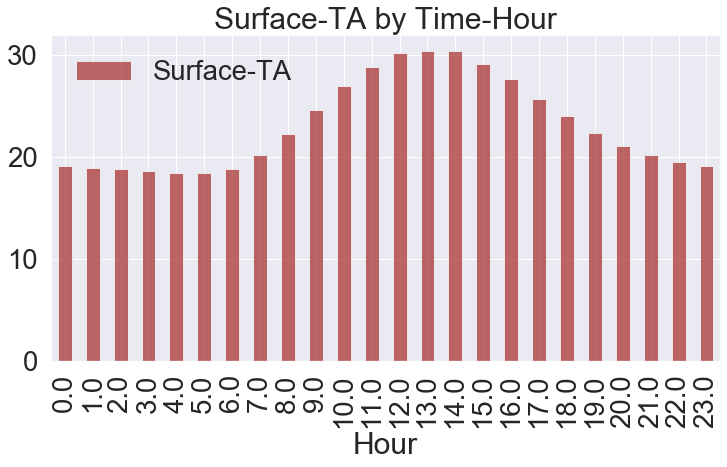

In [584]:
f, ax = plt.subplots(1, 1, figsize = (12,6))
df_20_0701[['Hour', 'Surface-TA']].groupby(['Hour'], as_index = True).mean().plot.bar(ax = ax, color = ['brown'], alpha = 0.7)
ax.set_title("Surface-TA by Time-Hour")

시간별로 측정되는 지표온도 변화를 확인할 수 있습니다.  
주로 밤에(10시~ 6시)는 낮게 측정되고 새벽 5시 이후로 온도가 상승하고 있습니다.  
온도는 계속해서 상승하다가 1시~2시경 최고온도를 달성합니다.  

Text(0.5, 1.0, 'Ground-TA by Time-Hour')

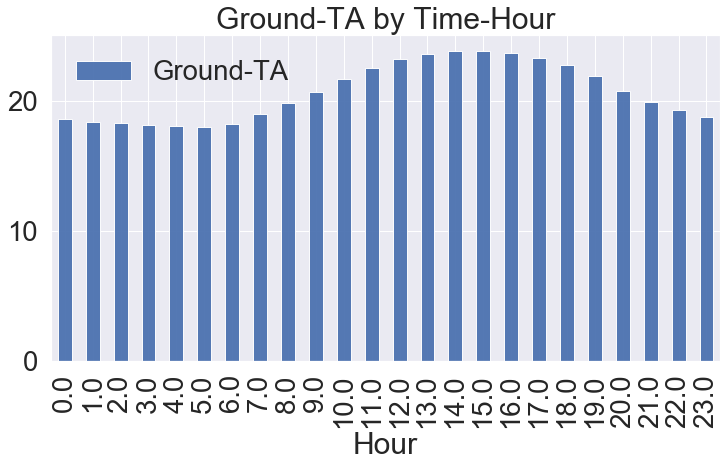

In [583]:
f, ax = plt.subplots(1, 1, figsize = (12,6))
df_20_0701[['Hour', 'Ground-TA']].groupby(['Hour'], as_index = True).mean().plot.bar(ax = ax,  color = ['b'], alpha = 0.95)
ax.set_title("Ground-TA by Time-Hour")

이번엔 지상온도 변화 그래프입니다.  
여름이라 그런지 온도가 대체적으로 높게 측정됩니다.  
밤에는 낮아지고 낮에 높아지는 변화 양상을 확인할 수 있습니다.  

In [537]:
df_20_0701[['STN', 'Ground-TA']].groupby(['STN'], as_index = True).count()

,Ground-TA
STN,
90,143
93,144
95,144
98,144
99,144
...,...
973,144
974,144
977,144


In [542]:

df_20_TMP = pd.read_csv('./20200803.LST.csv')
df_20_TMP.columns = ["YearMonthDayHourMinute","STN","Lon","Lat","Surface-TA","Band1","Band2",
                    "Band3","Band4","Band5","Band6","Band7","Band8","Band9","Band10","Band11",
                     "Band12","Band13","Band14","Band15","Band16","30daysBand3",
                    "30daysBand13","GK2A-LST","SolarZA","SateZA","ESR","Height","LandType",
                     "Ground-TA","insitu-HM","insitu-TD","insitu-TG","insitu-TED0.05","insitu-TED0.1",
                     "insitu-TED0.2","insitu-TED0.3","insitu-TED0.5","insitu-TED1.0",
                     "insitu-TED1.5","insitu-TED3.0","insitu-TED5.0","insitu-PA","insitu-PS"]
df_20_TMP[['STN', 'Ground-TA']].groupby(['STN'], as_index = True).count()

,Ground-TA
STN,
90,143
92,144
93,144
95,144
96,144
...,...
984,144
989,144
990,144


### 지역별 특성 고려

지역별 STN특성은 어떤기준으로 나뉘게 된 것인지 명확하지 않습니다.  
고로 지역별 온도 그래프를 확인해보겠습니다.  


Text(0.5, 1.0, 'Surface-TA by STN')

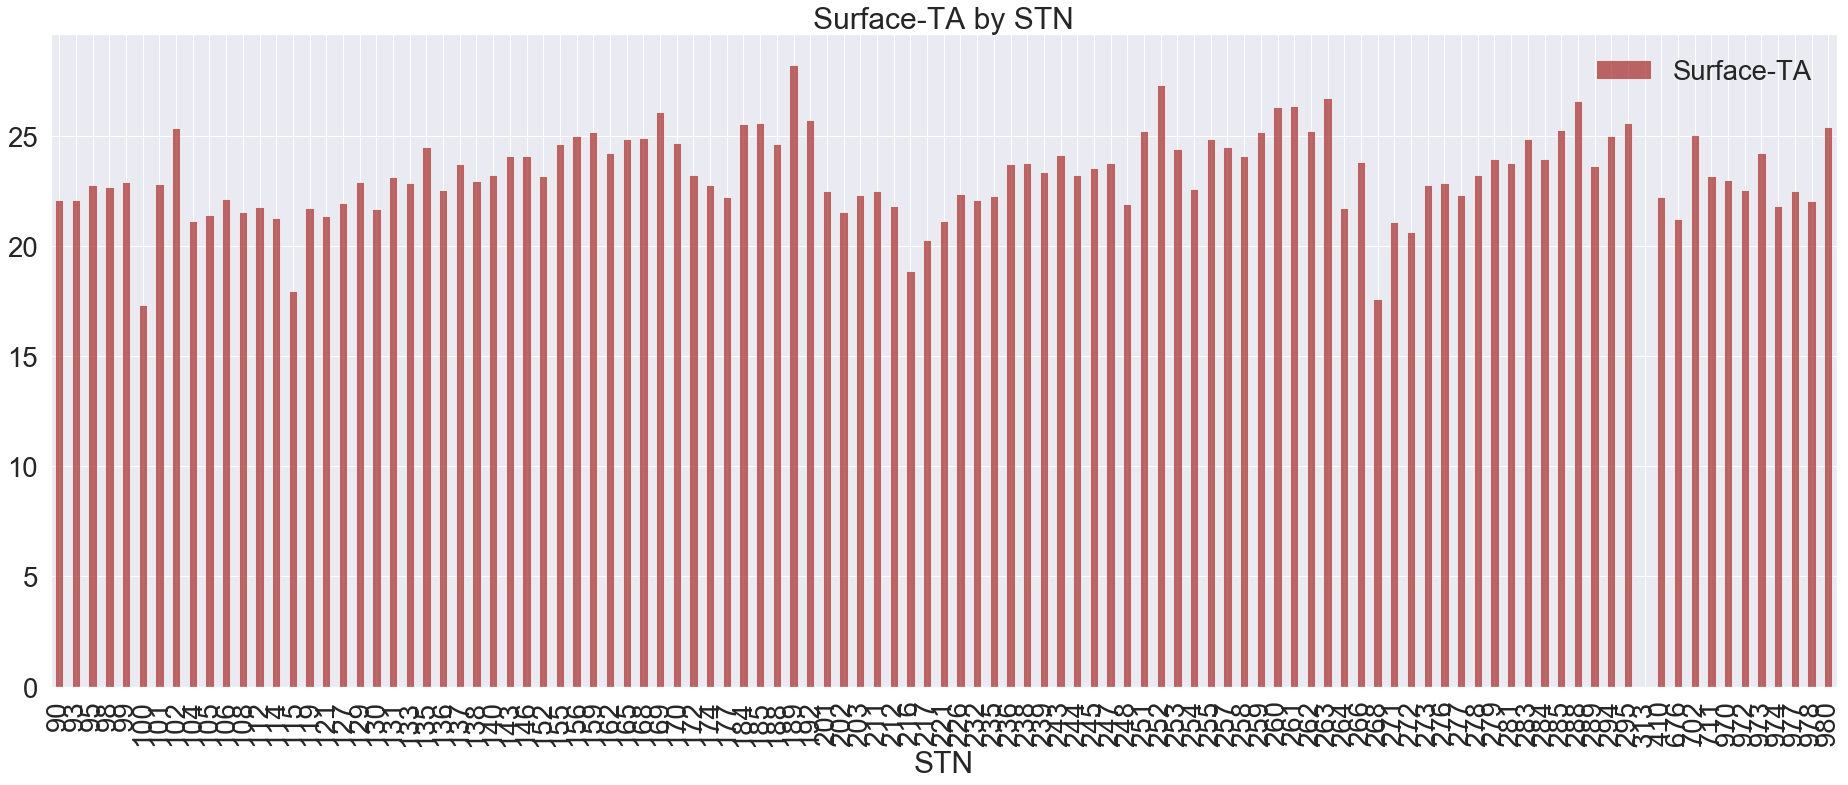

In [590]:
# 지표 온도
f, ax = plt.subplots(1, 1, figsize = (32,12))
df_20_0701[['STN', 'Surface-TA']].groupby(['STN'], as_index = True).mean().plot.bar(ax = ax, color = ['brown'], alpha = 0.7)
ax.set_title("Surface-TA by STN")


Text(0.5, 1.0, 'Ground-TA by STN')

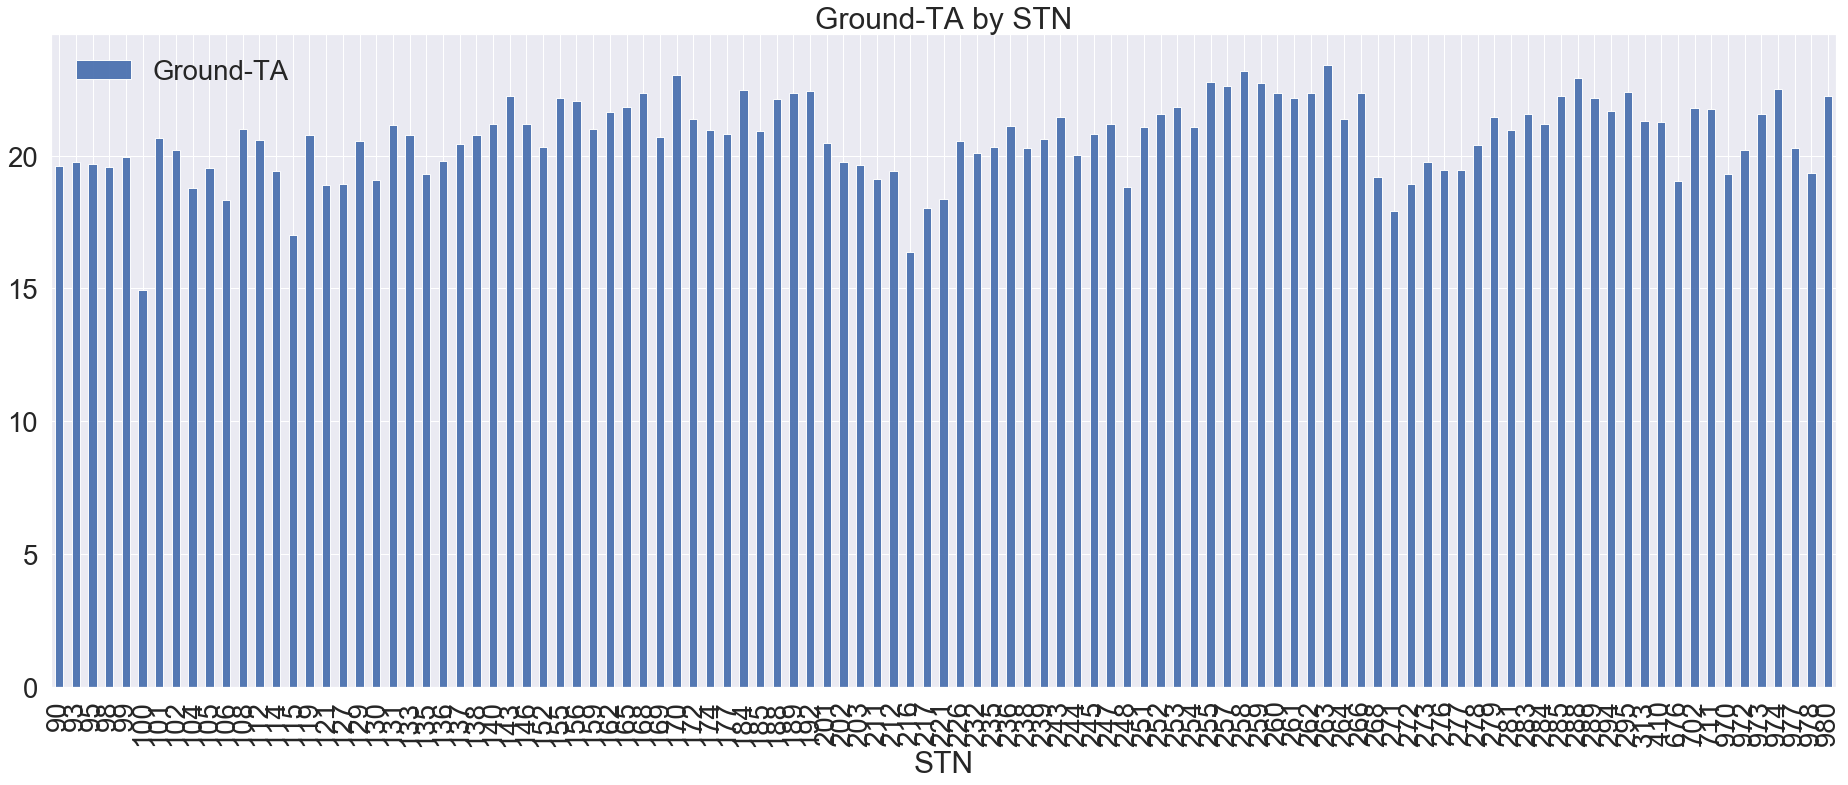

In [588]:
# 지상 온도
f, ax = plt.subplots(1, 1, figsize = (32,12))
df_20_0701[['STN', 'Ground-TA']].groupby(['STN'], as_index = True).mean().plot.bar(ax = ax,  color = ['b'], alpha = 0.95)
ax.set_title("Ground-TA by STN") ['brown'], 


각 지역마다 온도의 차이가 꽤나 있는것으로 보입니다.  
다만, STN의 범위는 (90 ~ 980)으로 기존의 시간(0 ~ 23)이나 월별 기준(1 ~ 12)의 범위보다 큽니다.  
또한 범주형데이터로 그대로 사용할 경우 회귀분석문제에서 risk가 발생할 수 있습니다.  
이는 뒤에 특성공학부분에서 더 다루겠습니다.  


### 태양 청천각 특성(SolarZA) 고려

이번에는 데이터 중 태양 청천각 지표를 고려해보겠습니다.  
태양 청천각 데이터는 지면과 수직방향에서 태양과 이루는 각도로  
이는 태양의 남중고도(지면과 수평방향)와 관계가 깊습니다.  
태양의 남중고도에 따라서 밤과 낮의 길이가 달라지고(지구의 자전, 공전 영향)  
이는 계절별 온도 차이를 발생시킵니다.  
또, 남중고도에 따라 단위 면적당 태양빛의 양 역시 차이가 나 기온에 영향을 끼칩니다.  
고로 태양 청천각 특성을 유의깊게 살펴보겠습니다.  


In [593]:
print("태양 청천각(SolarZA) 결측률:{0:0.1f}%".format((len(df_20_0701[df_20_0701["SolarZA"] == 0]) + len(df_20_0701[df_20_0701["SolarZA"] == -999]) )/ df_20_0701.shape[0] * 100))

태양 청천각(SolarZA) 결측률:0.0%


다음은 SolarZA별 지표온도와 지상온도 그래프를 확인해보겠습니다.


Text(0.5, 1.0, 'Ground-TA by SolarZA')

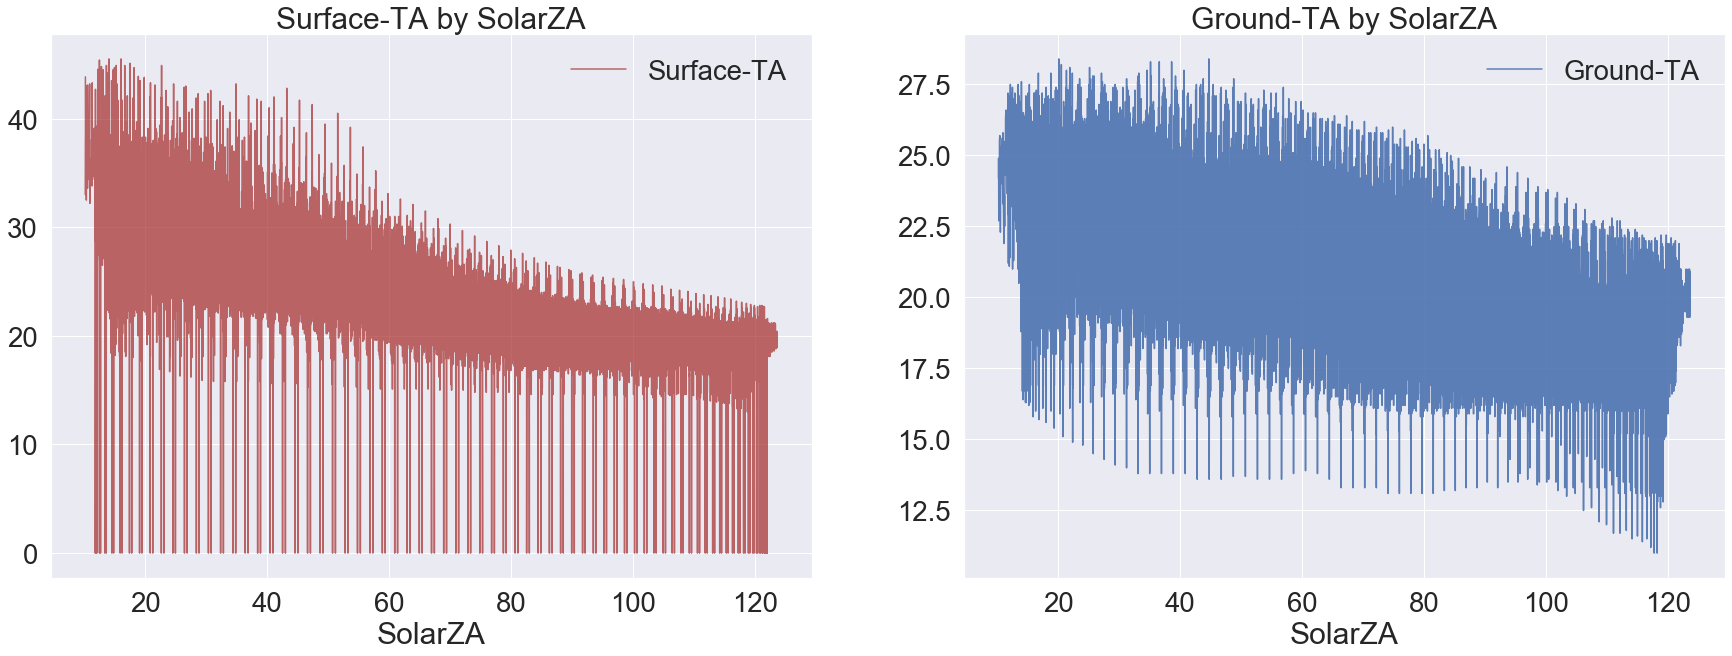

In [594]:
f, ax = plt.subplots(1, 2, figsize = (30,10))
# 지표 온도
df_20_0701[['SolarZA', 'Surface-TA']].groupby(['SolarZA'], as_index = True).mean().plot(ax = ax[0], color = ['brown'], alpha = 0.7)
ax[0].set_title("Surface-TA by SolarZA")
# 지상 온도
df_20_0701[['SolarZA', 'Ground-TA']].groupby(['SolarZA'], as_index = True).mean().plot(ax = ax[1], color = ['b'], alpha = 0.9)
ax[1].set_title("Ground-TA by SolarZA")


SolarZA가 낮게 관측될수록 지표온도와 지상온도 모두 살짝 높아지는 경향을 확인할 수 있습니다.  
중요한 데이터 지표임에도 데이터 이상치(Noise)가 심해서 모델에 안좋은 영향을 끼칠 가능성이 높습니다.  

#### 데이터 이상치 제거

고로 SolarZA데이터의 이상치를 어느정도 정리 해보겠습니다. 

In [596]:
max_solarZA = int(df_20_0701["SolarZA"].max())+1
for i in range(max_solarZA):
    df_20_0701.loc[ (i < df_20_0701.SolarZA)&(df_20_0701.SolarZA <= i+1),'SolarZA'] = df_20_0701.loc[ (i < df_20_0701.SolarZA)&(df_20_0701.SolarZA <= i+1)].mean()['SolarZA']

Text(0.5, 1.0, 'Ground-TA by SolarZA')

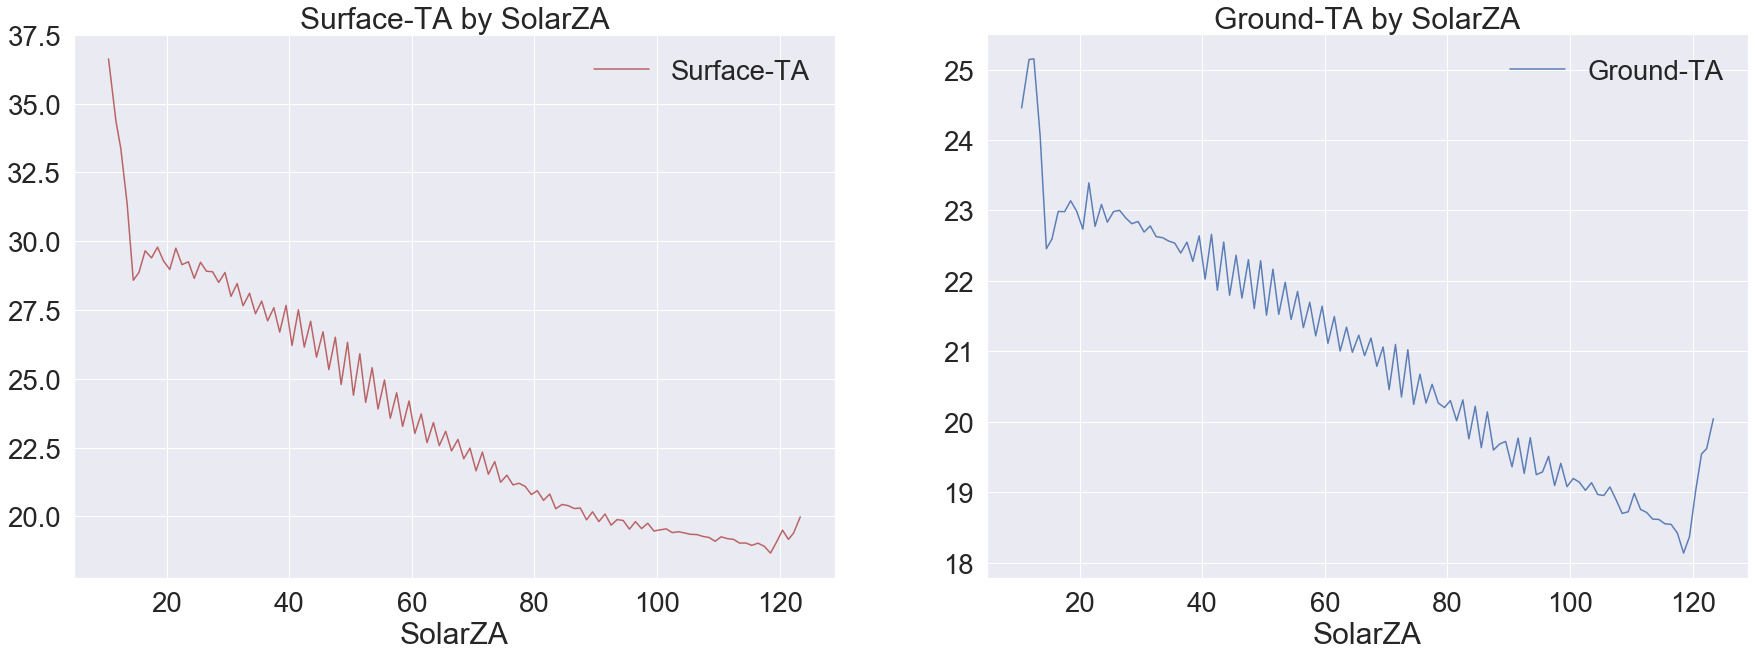

In [597]:
f, ax = plt.subplots(1, 2, figsize = (30,10))
# 지표 온도
df_20_0701[['SolarZA', 'Surface-TA']].groupby(['SolarZA'], as_index = True).mean().plot(ax = ax[0], color = ['brown'], alpha = 0.7)
ax[0].set_title("Surface-TA by SolarZA")
# 지상 온도
df_20_0701[['SolarZA', 'Ground-TA']].groupby(['SolarZA'], as_index = True).mean().plot(ax = ax[1], color = ['b'], alpha = 0.9)
ax[1].set_title("Ground-TA by SolarZA")


위와같이 태양청천각에 따른 온도변화를 좀 더 명확하게 나타내게 되었습니다.  
이렇게 하면 일종의 Noise값 없이 모델을 학습시킬 수 있습니다.
데이터를 탐색해보자면, 앞 서 조사해본바와 같이 태양청천각(수평 기준인 남중고도와 반비례, 하지만 관련 높음)  
이 높아질수록 온도는 하강하는 경향을 보입니다.(남중고도가 높으면 온도 높아짐)  


### 지면타입 데이터

이제 지면타입 데이터를 탐색해보겠습니다.  

Text(0.5, 1.0, 'Ground-TA by STN')

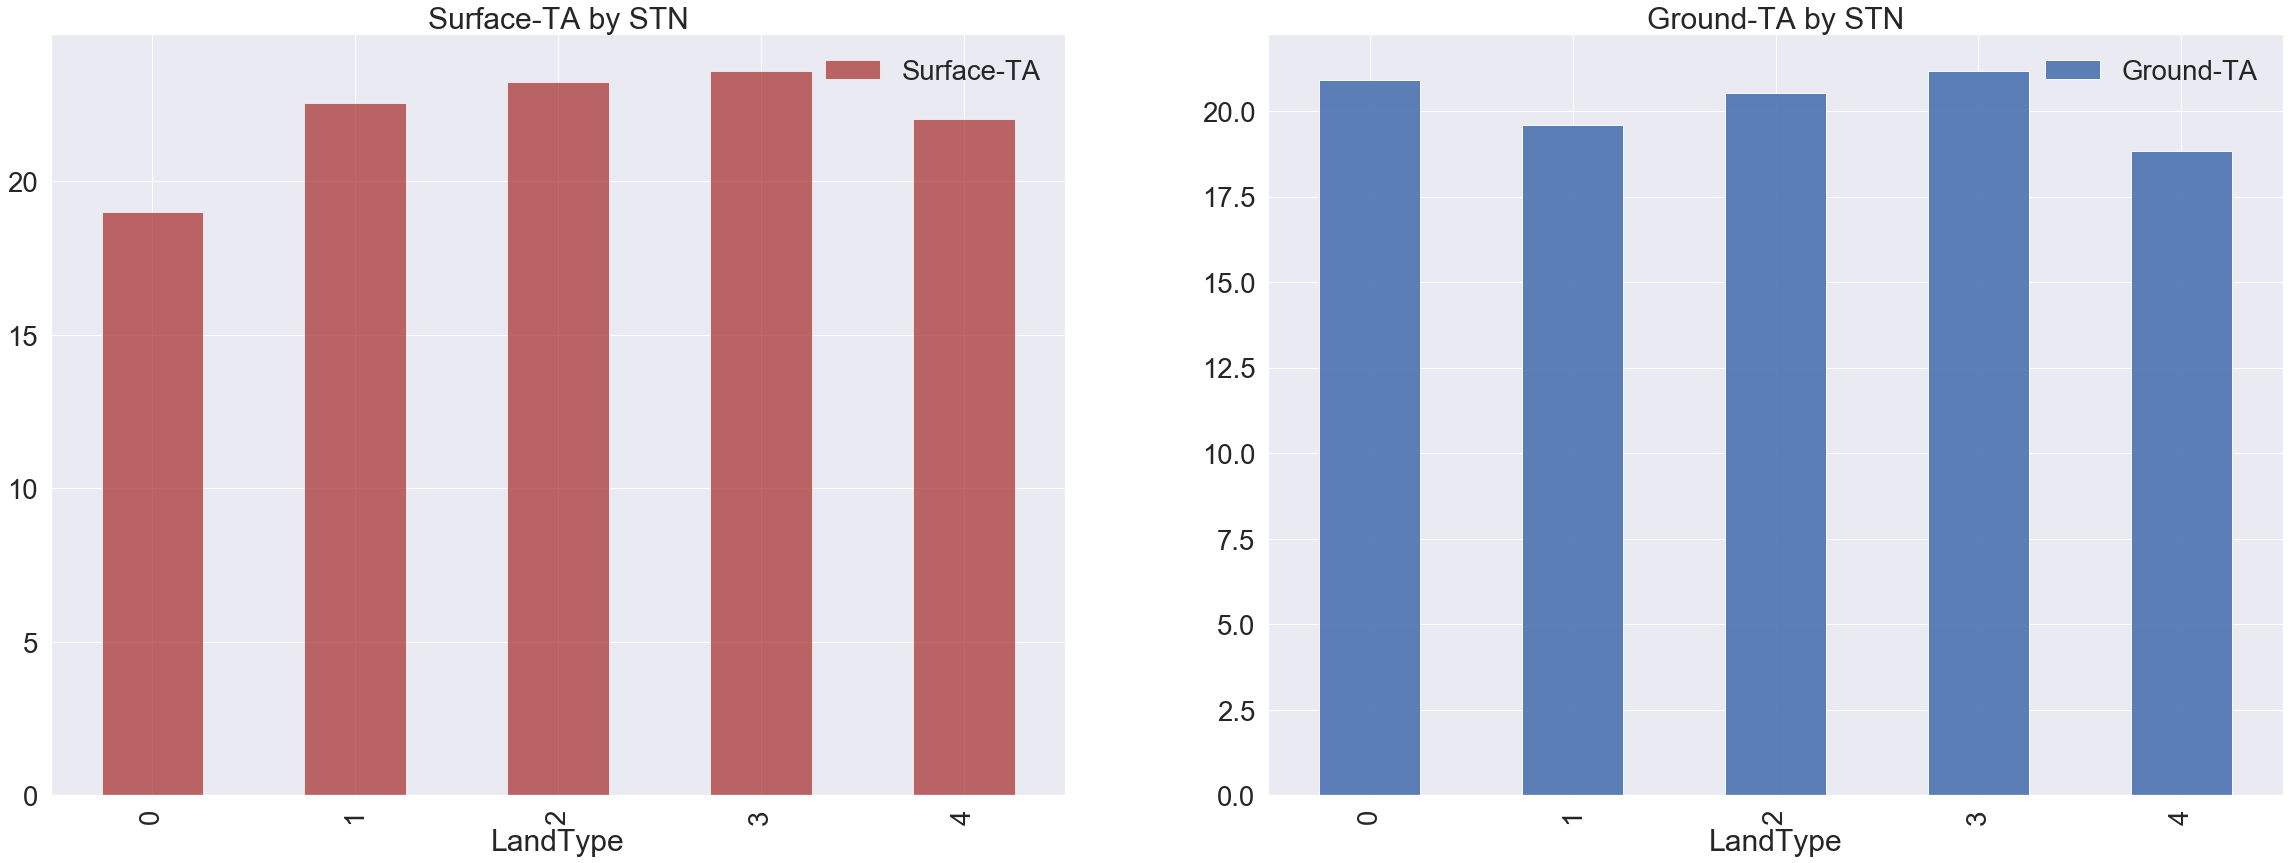

In [603]:


f, ax = plt.subplots(1, 2, figsize = (40,14))
# 지표 온도
df_20_0701[['LandType', 'Surface-TA']].groupby(['LandType'], as_index = True).mean().plot.bar(ax = ax[0],
                                                                                            color = ['brown'], alpha = 0.7)
ax[0].set_title("Surface-TA by STN")
# 지상 온도
df_20_0701[['LandType', 'Ground-TA']].groupby(['LandType'], as_index = True).mean().plot.bar(ax = ax[1],
                                                                                            color = ['b'], alpha = 0.9)
ax[1].set_title("Ground-TA by STN")


0,4: 습지혹은 해안가  
1: 산림지역  
2: 농지  
3: 도시

LandType의 숫자가 의미하는 바는 위와 같습니다.  
지표온도는 습지 혹은 해안가 지역의 온도가 상대적으로 낮게 나오고  
지상온도는 습지 혹은 해안가 중 한 지형은 높게, 한 지형은 낮게 나옵니다.  
산림, 농지, 도시 순으로 온도는 순차적으로 높아지는 경향이 보입니다.


### 확증적 데이터 분석(CDA, Confirmatory Data Analysis)

확증적 데이터 분석을 진행하겠습니다.  

In [ ]:
지금까지 시간("YearMonthDayHourMinute"), 지역("STN"), 지면타입("LandType"),  
태양 청천각("SolarZA")의 데이터 특성을 고려하고 정리했습니다.  
이제 남은 데이터는 기압과 습도 등(지상 관측)과 Band와 ESR 등(기상 위성 데이터)인데,  
이 데이터들은 직관적으로 지상온도, 지표온도와 일련의 관계를 가지는지 가늠하기 어렵습니다.  
좀 더 명확히 말하자면 지상온도, 지표온도를 예측하기 위한 Regreesion Model에서  
"일련의 규칙"을 가지는 중요한 데이터인지 알기가 힘듭니다.  

고로 지금부터 

#### 1.결과지표와 상관계수가 높은 데이터는 강한 상간관계를 가진다. 고로, 비례 혹은 반비례의
#### 관계가 있을 확률이 높고 이는 모델학습에 사용할만한 중요한 데이터일 수 있다.

#### 2.귀무가설과 대립가설  

위 2가지의 통계적 가설을 세우고  
p-value 검증, 데이터 분포도 확인을 통해 해당 가설을  
확인하고 이용해보겠습니다.  

피어슨 상관계수와 p_value 검증을 통해 위 2가지 가설에 부합하는
데이터들을 추출해보고 데이터 그래프 및 모형을 그려보면서 확인해보겠습니다.  

(두 변수간의 상관관계가 인과관계를 설명하지는 못합니다. 다만, 피어슨 상관계수는  
두 변수간의 음 또는 양의 상관성을 입증합니다. 이는 두 변수간의 선형적인 관계가 있음을  
의미하고 기계학습을 진행할때 일종의 규칙성을 가질 확률이 높습니다.  
명확한 인과관계에 따라 변수간의 증명식을 구하고자 한다면 추가적인 연구가 필요하겠으나,  
지금은 지표온도, 지상온도와 연관있는 regression 모델 데이터를 구하는 것이 중요하므로    
위 과정과 더불어 데이터분포 그래프를 그려보고 정말 선형적 관계를 가지는지,  
이상치 값을 가지는지를 확인하면서 의미있어 보이는 데이터들을 탐색해보겠습니다.)


Pearson 상관계수와 P_value 검증법에 따라서 데이터 추출기준을 정립해보겠습니다.  

#### Pearson 계수  

0.0~0.1: 거의 관계없음  

0.1~0.2: 약한 양의 상관관계  

0.2~0.4: 보통의 양의 상관관계  

0.4~0.6: 비교적 강한 양의 상관관계  

0.6~0.8: 강한 양의 관계  

0.8~1.0: 매우 강한 양의 상관관계   

(Rea, L. M., & Parker, R.A. (2005). Designing & Conducting Survey Research A Comprehensive Guide (3rd Edition). San Francisco, CA: Jossey-Bass.)
위의 통계분석 조사 자료를 참고하면 위와 같은 Pearson 분류 기준을 확인할 수 있습니다.  
이 중Pearson 계수 절댓값 0.6 이상의 강한 음,양의 관계를 가지는 데이터를 추출 기준을 삼겠습니다.

#### P_value 검증

1) 귀무가설
: 두 변수간 아무 영향, 관계가 없다고 가정합니다.(p_value가 유의수준a보다 큰 경우)
    
2) 대립가설
: 두 변수간 일종의 관계, 이유가 있다고 가정합니다.(p_value가 유의수준a보다 작은 경우)

p_value 검증과 관련된 통계적 가설입니다. 이때 유의수준은 사건이 우연히 일어날 확률을 의미하고  
p_value가 a(0.1)보다 작다는 것은 어떤 사건이 우연히 일어날 확률이 10%보다 작다는 뜻입니다.

a를 0.05로 두고 p_value가 0.05보다 작으면 귀무가설을 기각하고 대립가설을 택하겠습니다.


### 상관계수 분석

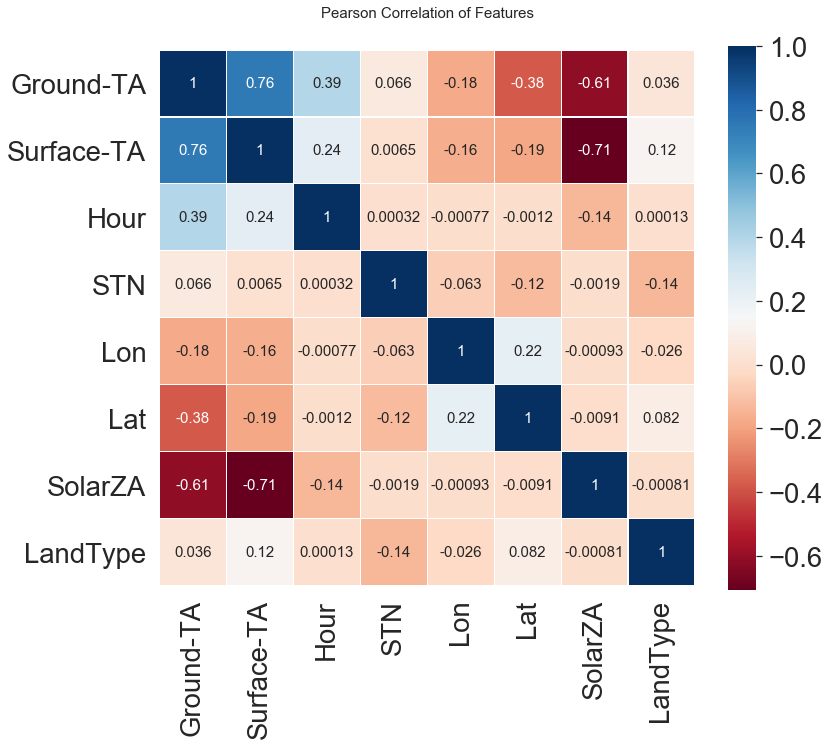

In [621]:
heatmap_data = df_20_0701[["Ground-TA","Surface-TA","Hour","STN","Lon","Lat",
                    "SolarZA","LandType"]]

colormap = plt.cm.RdBu
plt.figure(figsize = (12, 10))
plt.title('Pearson Correlation of Features', y = 1.05, size = 15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, square = True,
           cmap = colormap, linecolor = 'white', annot = True, annot_kws={"size":15})


del heatmap_data

먼저 기존에 정리한 데이터 특성들과 지표온도(Surface), 지상온도(Ground)간의  
상관계수표입니다.  
어느정도 상관관계를 보이는 데이터(0.2~0.4 이상) 지표는 SolarZA와 시간, 지역(STN, STN_mean)이 있습니다.  


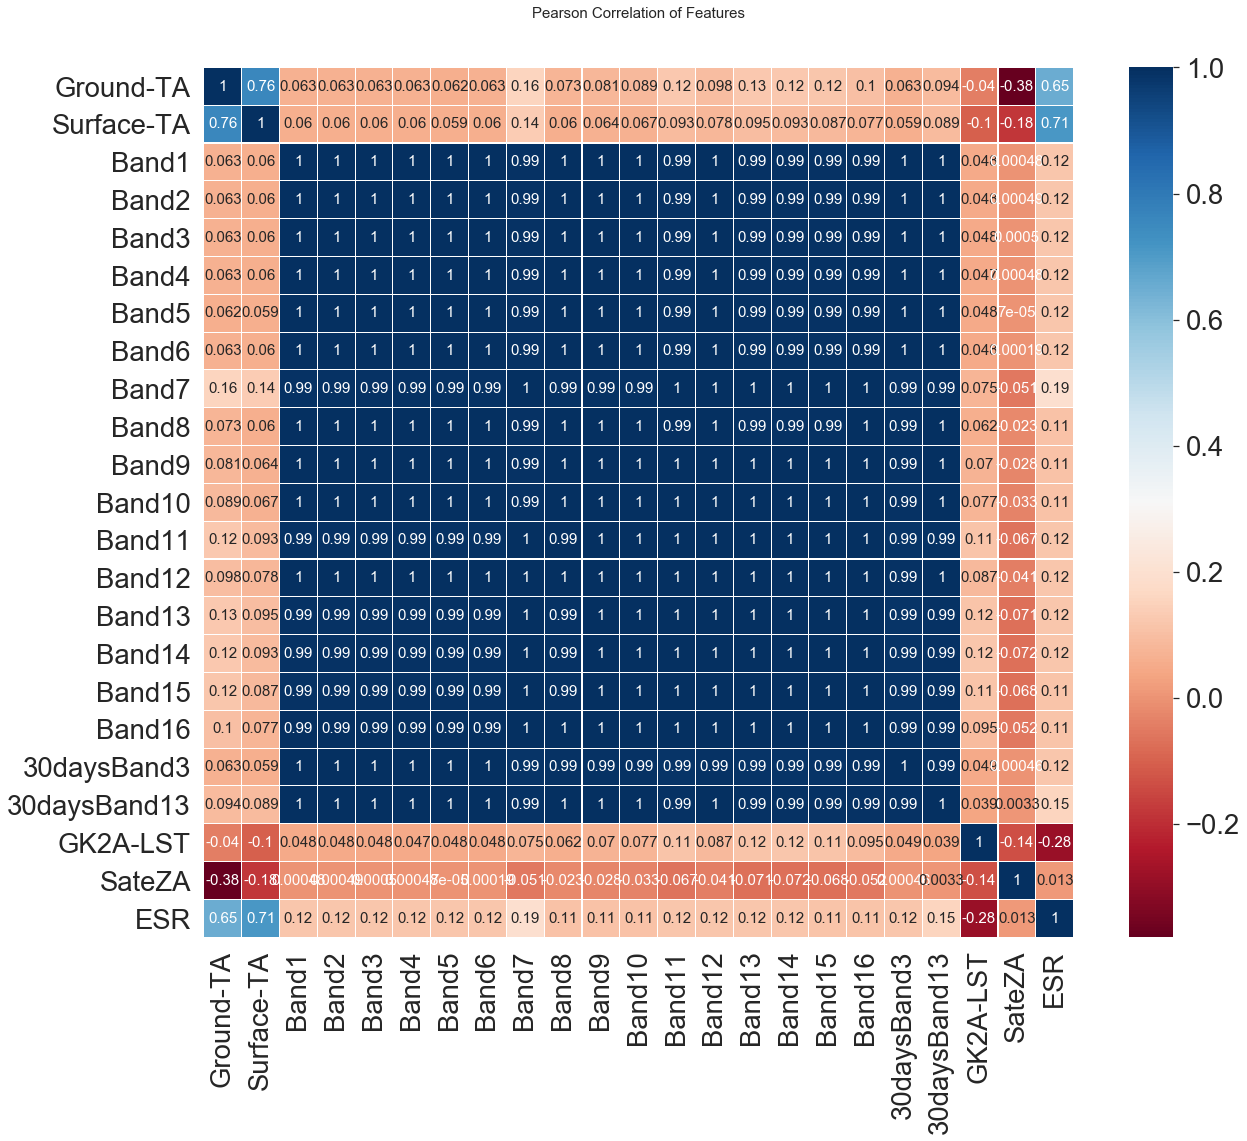

In [623]:
heatmap_data = df_20_0701[["Ground-TA","Surface-TA","Band1","Band2",
                    "Band3","Band4","Band5","Band6","Band7","Band8","Band9","Band10","Band11",
                     "Band12","Band13","Band14","Band15","Band16","30daysBand3",
                    "30daysBand13","GK2A-LST","SateZA","ESR"
                     ]]

colormap = plt.cm.RdBu
plt.figure(figsize = (20, 16))
plt.title('Pearson Correlation of Features', y = 1.05, size = 15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, square = True,
           cmap = colormap, linecolor = 'white', annot = True, annot_kws={"size":15})

del heatmap_data

기타 기상위성 데이터와 지표온도(Surface), 지상온도(Ground)간의 상관계수표입니다.  


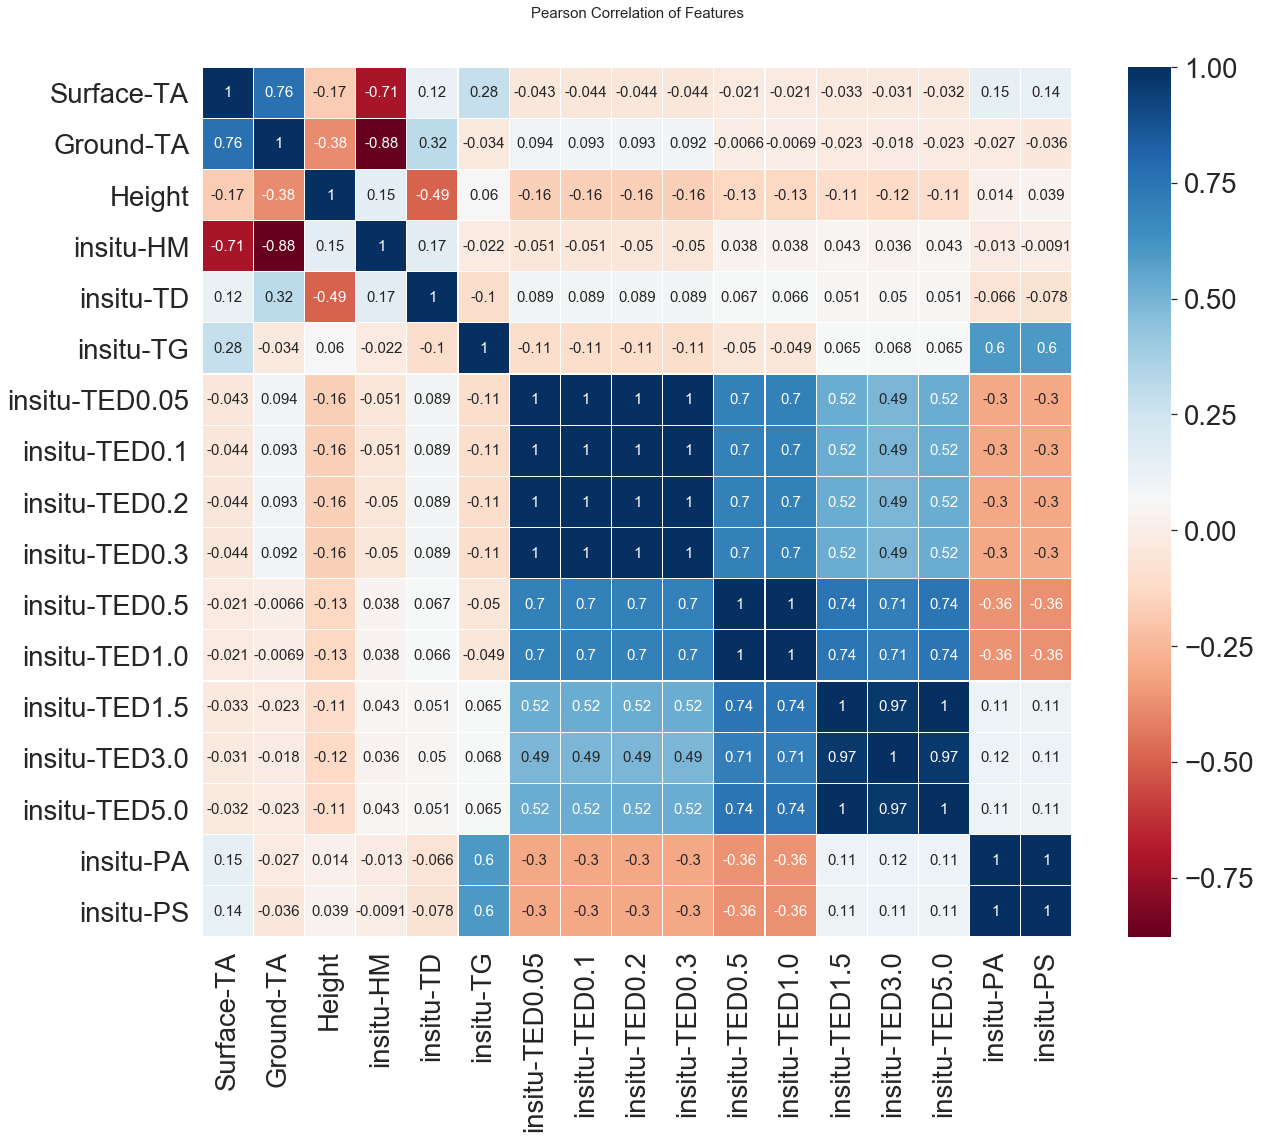

In [625]:
heatmap_data = df_20_0701[["Surface-TA",
                     "Ground-TA","Height","insitu-HM","insitu-TD","insitu-TG","insitu-TED0.05","insitu-TED0.1",
                     "insitu-TED0.2","insitu-TED0.3","insitu-TED0.5","insitu-TED1.0",
                     "insitu-TED1.5","insitu-TED3.0","insitu-TED5.0","insitu-PA","insitu-PS"]]

colormap = plt.cm.RdBu
plt.figure(figsize = (20, 16))
plt.title('Pearson Correlation of Features', y = 1.05, size = 15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, square = True,
           cmap = colormap, linecolor = 'white', annot = True, annot_kws={"size":15})

del heatmap_data

기타 지상관측 데이터와 지표온도(Surface), 지상온도(Ground)간의 상관계수표입니다.  


In [645]:
import scipy.stats as stats

def get_p_value(data_list):
    surface_p_values = []
    ground_p_values = []
    surface_total_values = []
    ground_total_values = []
    
    for i in data_list:
        surface_p_value = stats.pearsonr(df_20_0701['Surface-TA'],df_20_0701[i])
        ground_p_value = stats.pearsonr(df_20_0701['Ground-TA'],df_20_0701[i])
        
        print("Surface-TA 와 {0}의 pearson 계수: {1:0.2f}, p_value: {2:0.4f}".format(i,df_20_0701[["Surface-TA",i]].corr(method = 'pearson')[i][0]
        ,surface_p_value[1]))
        print("Ground-TA 와 {0}의 pearson 계수: {1:0.2f}, p_value: {1:0.4f}".format(i,df_20_0701[["Ground-TA",i]].corr(method = 'pearson')[i][0]
        ,ground_p_value[1]))
        print()
        
        # 유의수준 alpha 값: 0.05(5%)이하 check
        if surface_p_value[1] <= 0.05:
            surface_p_values.append(i)
        if ground_p_value[1] <= 0.05:
            ground_p_values.append(i)
    
    # perason 계수 check(강한 상관관계를 가지는)
    for i in surface_p_values:
        if (df_20_0701[["Surface-TA",i]].corr(method = 'pearson')[i][0] <= -0.6) or (df_20_0701[["Surface-TA",i]].corr(method = 'pearson')[i][0] >=0.6):
                surface_total_values.append(i)
                
    for i in ground_p_values:
        if (df_20_0701[["Ground-TA",i]].corr(method = 'pearson')[i][0] <= -0.6) or (df_20_0701[["Ground-TA",i]].corr(method = 'pearson')[i][0] >=0.6):
                ground_total_values.append(i)
    
    
    print("지표온도와 p_value 귀무가설을 기각하고(통계적으로 결과값 변수와 유의미한 상과관계를 가지는)\n강한 상관관계를 가지는 변수들:",end= '')
            
    for i in range(len(surface_total_values)):
        if i == len(surface_total_values) -1:
            print(surface_total_values[i])
            continue
        print(surface_total_values[i],end= ',')
    
    print()
    print("지상온도와 p_value 귀무가설을 기각하고(통계적으로 결과값 변수와 유의미한 상과관계를 가지는)\n강한 상관관계를 가지는 변수들:",end= '')
    
    for i in range(len(ground_total_values)):
        if i == len(ground_total_values) -1:
            print(ground_total_values[i])
            continue
        print(ground_total_values[i],end= ',')

    
        
    return
get_p_value(["Band1","Band2","Band3","Band4","Band5","Band6","Band7","Band8","Band9","Band10","Band11",
                     "Band12","Band13","Band14","Band15","Band16","30daysBand3",
                    "30daysBand13","GK2A-LST","SateZA","ESR","Height",
                    "insitu-HM","insitu-TD","insitu-TG","insitu-TED0.05","insitu-TED0.1",
                     "insitu-TED0.2","insitu-TED0.3","insitu-TED0.5","insitu-TED1.0",
                     "insitu-TED1.5","insitu-TED3.0","insitu-TED5.0","insitu-PA","insitu-PS"])


Surface-TA 와 Band1의 pearson 계수: 0.06, p_value: 0.0000
Ground-TA 와 Band1의 pearson 계수: 0.06, p_value: 0.0630

Surface-TA 와 Band2의 pearson 계수: 0.06, p_value: 0.0000
Ground-TA 와 Band2의 pearson 계수: 0.06, p_value: 0.0629

Surface-TA 와 Band3의 pearson 계수: 0.06, p_value: 0.0000
Ground-TA 와 Band3의 pearson 계수: 0.06, p_value: 0.0629

Surface-TA 와 Band4의 pearson 계수: 0.06, p_value: 0.0000
Ground-TA 와 Band4의 pearson 계수: 0.06, p_value: 0.0633

Surface-TA 와 Band5의 pearson 계수: 0.06, p_value: 0.0000
Ground-TA 와 Band5의 pearson 계수: 0.06, p_value: 0.0622

Surface-TA 와 Band6의 pearson 계수: 0.06, p_value: 0.0000
Ground-TA 와 Band6의 pearson 계수: 0.06, p_value: 0.0630

Surface-TA 와 Band7의 pearson 계수: 0.14, p_value: 0.0000
Ground-TA 와 Band7의 pearson 계수: 0.16, p_value: 0.1590

Surface-TA 와 Band8의 pearson 계수: 0.06, p_value: 0.0000
Ground-TA 와 Band8의 pearson 계수: 0.07, p_value: 0.0734

Surface-TA 와 Band9의 pearson 계수: 0.06, p_value: 0.0000
Ground-TA 와 Band9의 pearson 계수: 0.08, p_value: 0.0808

Surface-TA 와 Band10의 pearson

In [ ]:
# 위코드는 pearson 계수 0.2로 돌린 결과입니다. 모두 0.6으로 맞춰주면 최종공모안처럼 ESR,insitu-TG 값만 나오게 됩니다.

#### Select columns and Data Import

위의 통계적 가설을 탐색해보기 위해 데이터들을 정리하겠습니다.    
또 특성공학을 적용할것이기 때문에 하루가 아닌, 전체 데이터를 불러와서 진행하겠습니다.  
지표온도와 지상온도를 예측해야 하므로 두가지 데이터set이 필요합니다.  

In [ ]:
import glob


all_data = []
all_files = glob.glob(os.path.join("C:\\Users\\jooyon\\AI\\Degree_Forcast","*.csv"))

for file in all_files:
    df_tmp = pd.read_csv(file)
    if df_tmp.shape[1] != 44:
        continue
    
        
    df_tmp.columns = ["YearMonthDayHourMinute","STN","Lon","Lat","Surface-TA","STN_area","Band2",
                    "Band3","Band4","Band5","Band6","Band7","Band8","Band9","Band10","Band11",
                     "Band12","Band13","Band14","Band15","Band16","30daysBand3",
                    "30daysBand13","GK2A-LST","SolarZA","SateZA","ESR","Height","LandType",
                     "Ground-TA","insitu-HM","insitu-TD","insitu-TG","insitu-TED0.05","insitu-TED0.1",
                     "insitu-TED0.2","insitu-TED0.3","insitu-TED0.5","insitu-TED1.0",
                     "insitu-TED1.5","insitu-TED3.0","insitu-TED5.0","insitu-PA","insitu-PS"]
    

    # 데이터 결측치 처리
    df_tmp = df_tmp[df_tmp['Surface-TA'] != -999]
    df_tmp = df_tmp[df_tmp['Ground-TA'] != -999]
    
    df_tmp = df_tmp[['YearMonthDayHourMinute','insitu-TD','insitu-TG',
       'SolarZA','ESR','Lon','Lat',
       'insitu-HM','LandType','STN','Surface-TA','Ground-TA']]

    
    all_data.append(df_tmp)

# all_data_tmp = map(pd.read_csv, all_files)
df = pd.concat(all_data, axis = 0,ignore_index=True)

In [ ]:
# 지역별 STN_area 생성
df.loc[ (37.1 < df.Lat)&(df.Lat <= 38.5)&(124.5<df.Lon)&(df.Lon <= 127.7),'STN_area'] = 0
df.loc[ (37.1 < df.Lat)&(df.Lat <= 38.5)&(127.7<df.Lon)&(df.Lon <= 131),'STN_area'] = 1
df.loc[ (36.05 < df.Lat)&(df.Lat <= 37.1)&(126.1<df.Lon)&(df.Lon <= 127.3),'STN_area'] = 2
df.loc[ (36.05 < df.Lat)&(df.Lat <= 37.1)&(127.3<df.Lon)&(df.Lon <= 127.9),'STN_area'] = 3
df.loc[ (36.78 < df.Lat)&(df.Lat <= 37.1)&(127.9<df.Lon)&(df.Lon <= 128.39),'STN_area'] = 3
df.loc[ (36.78 < df.Lat)&(df.Lat <= 37.1)&(128.39<df.Lon)&(df.Lon <= 129.5),'STN_area'] = 4
df.loc[ (35.66 < df.Lat)&(df.Lat <= 36.78)&(127.9<df.Lon)&(df.Lon <= 129.57),'STN_area'] = 4
df.loc[ (34.7 < df.Lat)&(df.Lat <= 35.66)&(127.9<df.Lon)&(df.Lon <= 129.57),'STN_area'] = 5
df.loc[ (35.32 < df.Lat)&(df.Lat <= 36.05)&(126.38<df.Lon)&(df.Lon <= 127.9),'STN_area'] = 6
df.loc[ (34.09 < df.Lat)&(df.Lat <= 35.32)&(125<df.Lon)&(df.Lon <= 127.9),'STN_area'] = 7
df.loc[ (33.18 < df.Lat)&(df.Lat <= 33.56)&(126.14<df.Lon)&(df.Lon <= 127),'STN_area'] = 8

In [634]:
surface_df =  df[["YearMonthDayHourMinute",
    'SolarZA','STN','STN_area','LandType','ESR',
       'insitu-HM','Surface-TA']]

ground_df= df[["YearMonthDayHourMinute",
        'SolarZA','STN','STN_area','LandType','ESR',
       'insitu-HM','Ground-TA']]


In [ ]:
### 월별 요소를 고려하기 위해 Month 추가
for i in range(13):
    surface_df.loc[ ((surface_df['YearMonthDayHourMinute']%100000000)//1000000 == i),'Month'] = i
    ground_df.loc[ ((ground_df['YearMonthDayHourMinute']%100000000)//1000000 == i),'Month'] = i

for i in range(24):
    surface_df.loc[ ((surface_df['YearMonthDayHourMinute']%10000)//100 == i),'Hour'] = i
    ground_df.loc[ ((ground_df['YearMonthDayHourMinute']%10000)//100 == i),'Hour'] = i


In [ ]:
# 결측치(null값) 제거
surface_df = surface_df.dropna(axis = 0)
ground_df = ground_df.dropna(axis = 0)


대기외 일사랑(ESR)과 습도(insitu-HM)와 지표/지상 온도간의 그래프를 확인해보겠습니다.

Text(0.5, 1.0, 'Ground-TA by HM')

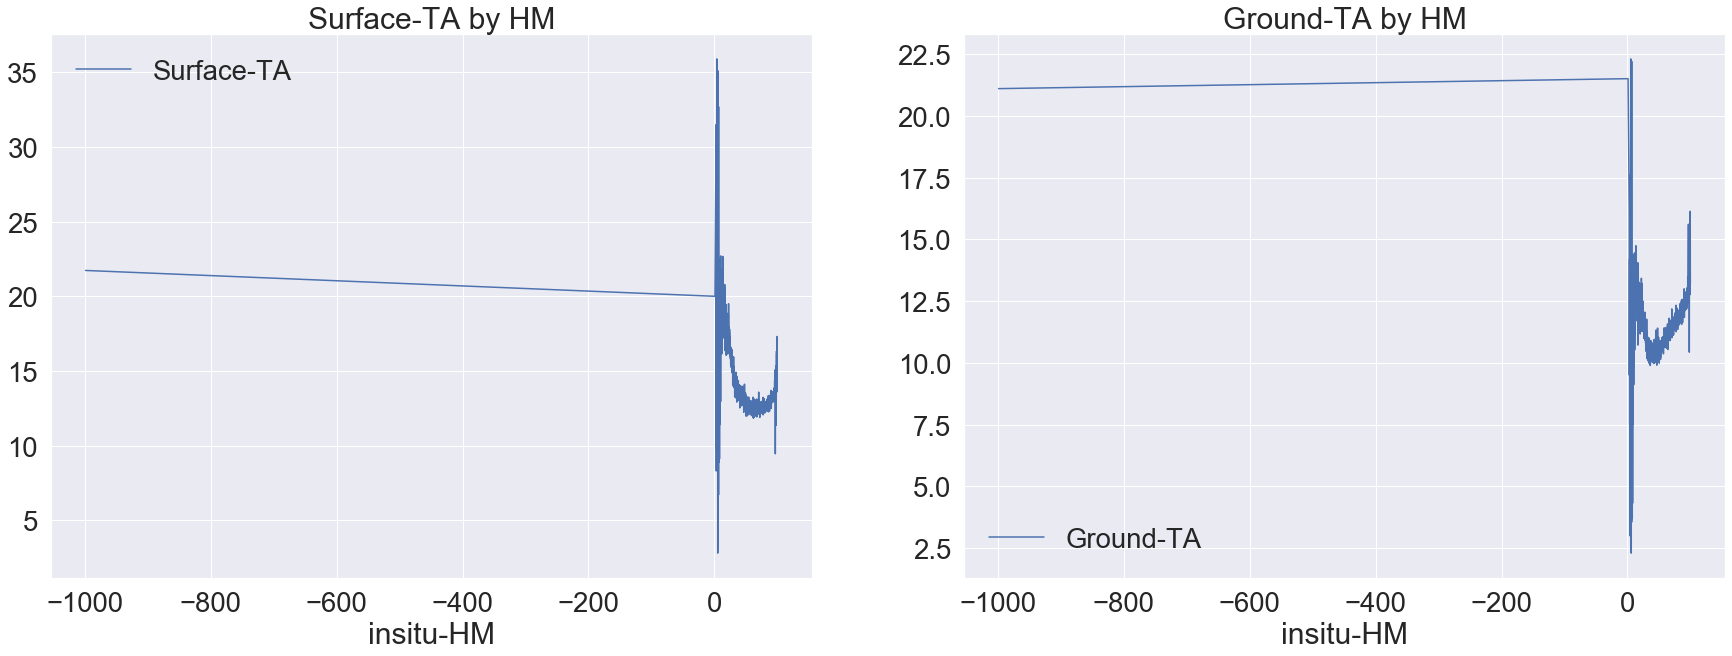

In [640]:
f, ax = plt.subplots(1, 2, figsize = (30,10))
# 지표 온도
df_20_0701[['insitu-HM', 'Surface-TA']].groupby(['insitu-HM'], as_index = True).mean().plot(ax = ax[0], color = ['brown'], alpha = 0.7)
ax[0].set_title("Surface-TA by insitu-HM")
# 지상 온도
df_20_0701[['insitu-HM', 'Ground-TA']].groupby(['insitu-HM'], as_index = True).mean().plot(ax = ax[1], color = ['b'], alpha = 0.9)
ax[1].set_title("Ground-TA by insitu-HM")


Text(0.5, 1.0, 'Ground-TA by 30daysBand13')

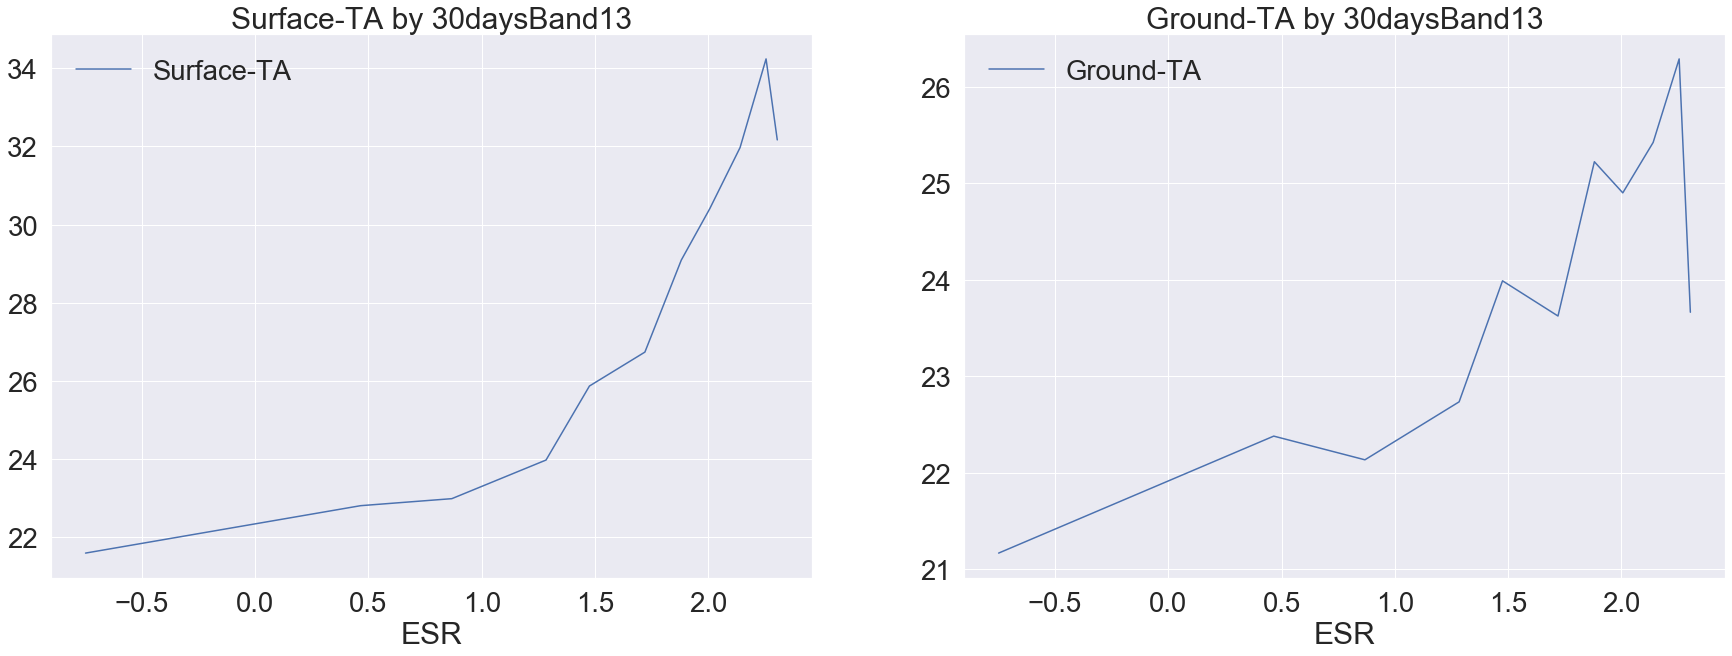

In [624]:
f, ax = plt.subplots(1, 2, figsize = (30,10))
# 지표 온도
df_20_0701[['ESR', 'Surface-TA']].groupby(['ESR'], as_index = True).mean().plot(ax = ax[0], color = ['brown'], alpha = 0.7)
ax[0].set_title("Surface-TA by ESR")
# 지상 온도
df_20_0701[['ESR', 'Ground-TA']].groupby(['ESR'], as_index = True).mean().plot(ax = ax[1], color = ['b'], alpha = 0.9)
ax[1].set_title("Ground-TA by ESR")


위와 같은 그래프가 나옵니다. 습도그래프의 경우, 결측치가 있는것으로 보입니다.  
고로 결측치와 이상치를 제거한뒤 다시 확인하겠습니다.  


In [643]:
surface_df = surface_df[surface_df["insitu-HM"] != -999]
surface_df = surface_df[surface_df["insitu-HM"] != -999]


In [ ]:

s_max = int(surface_df["insitu-HM"].max())+1
g_max = int(ground_df["insitu-HM"].max())+1

for i in range(s_max):
    surface_df.loc[ (i < surface_df["insitu-HM"])&(surface_df["insitu-HM"] <= i+1),'insitu-HM'] = surface_df.loc[ (i < surface_df["insitu-HM"])&(surface_df["insitu-HM"] <= i+1)].mean()['insitu-HM']
    
for i in range(g_max):    
    ground_df.loc[ (i < ground_df["insitu-HM"])&(ground_df["insitu-HM"] <= i+1),'insitu-HM'] = ground_df.loc[ (i < ground_df["insitu-HM"])&(ground_df["insitu-HM"]<= i+1)].mean()['insitu-HM']


In [ ]:
s_max = int(surface_df["ESR"].max())+1
g_max = int(ground_df["ESR"].max())+1

for i in range(s_max):
    surface_df.loc[ (i < surface_df["ESR"])&(surface_df["ESR"] <= i+1),'ESR'] = surface_df.loc[ (i < surface_df["ESR"])&(surface_df["ESR"] <= i+1)].mean()['ESR']
    surface_df.loc[ (-i-1 < surface_df["ESR"])&(surface_df["ESR"] <= -i),'ESR'] = surface_df.loc[ (-i-1 < surface_df["ESR"])&(surface_df["ESR"] <= -i)].mean()['ESR']
    
for i in range(g_max):    
    ground_df.loc[ (i < ground_df["ESR"])&(ground_df["ESR"] <= i+1),'ESR'] = ground_df.loc[ (i < ground_df["ESR"])&(ground_df["ESR"]<= i+1)].mean()['ESR']
    ground_df.loc[ (-i-1 < ground_df["ESR"])&(ground_df["ESR"] <= -i),'ESR'] = ground_df.loc[ (-i-1 < ground_df["ESR"])&(ground_df["ESR"] <= -i)].mean()['ESR']
    


Text(0.5, 1.0, 'Ground-TA by HM')

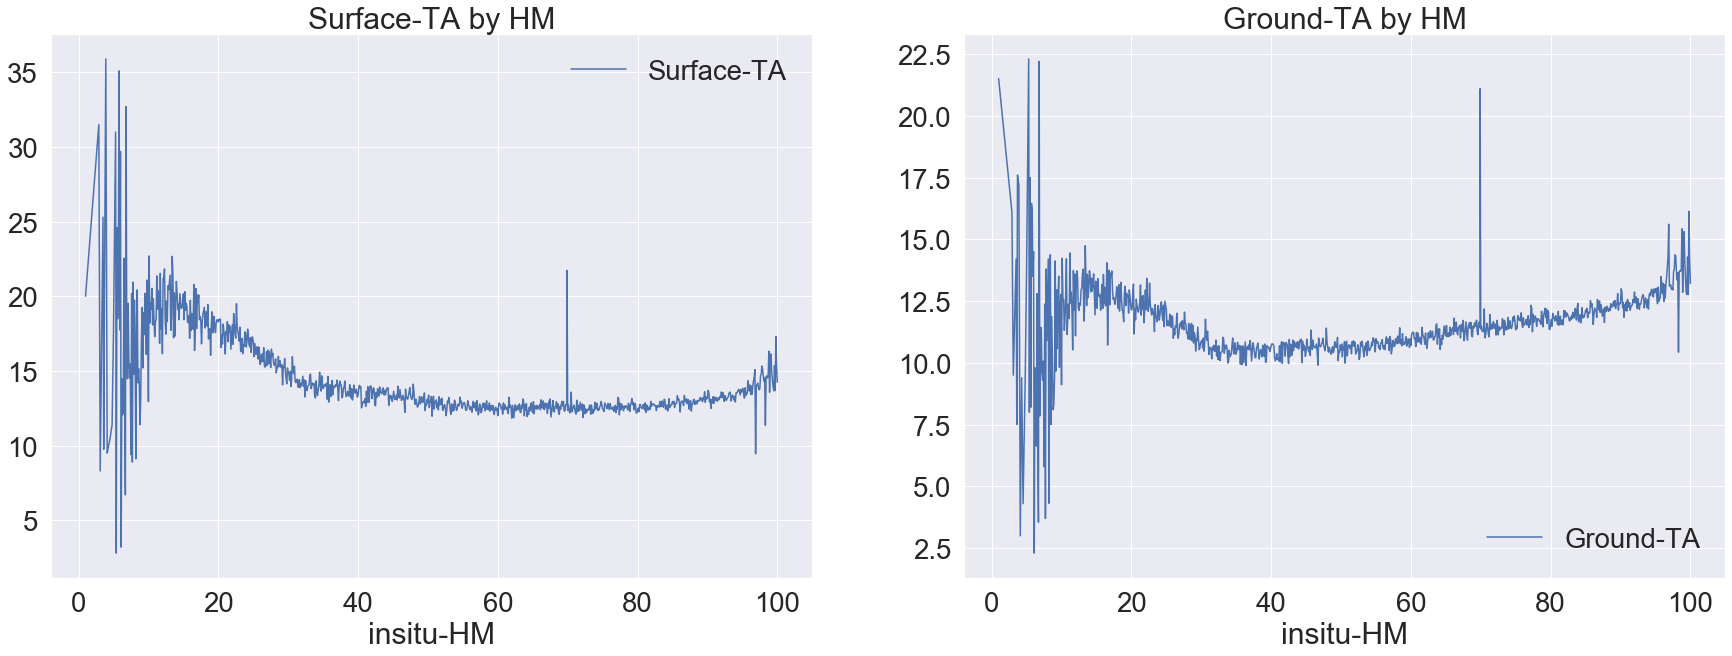

In [644]:
f, ax = plt.subplots(1, 2, figsize = (30,10))
# 지표 온도
surface_df[['insitu-HM', 'Surface-TA']].groupby(['insitu-HM'], as_index = True).mean().plot(ax = ax[0])
ax[0].set_title("Surface-TA by HM")
# 지상 온도
ground_df[['insitu-HM', 'Ground-TA']].groupby(['insitu-HM'], as_index = True).mean().plot(ax = ax[1])
ax[1].set_title("Ground-TA by HM")

In [ ]:
f, ax = plt.subplots(1, 2, figsize = (30,10))
# 지표 온도
df_20_0701[['ESR', 'Surface-TA']].groupby(['ESR'], as_index = True).mean().plot(ax = ax[0], color = ['brown'], alpha = 0.7)
ax[0].set_title("Surface-TA by ESR")
# 지상 온도
df_20_0701[['ESR', 'Ground-TA']].groupby(['ESR'], as_index = True).mean().plot(ax = ax[1], color = ['b'], alpha = 0.9)
ax[1].set_title("Ground-TA by ESR")


위와 같이 지표가 나왔습니다.  
ESR지표는 확실하게 선형적인 관계를 보이고 있고 HM지표는 20까지는  
온도가 상승하다가 그 이후부터는 온도가 하강하는 지표를 보입니다.  
 이 정도의 데이터 변화는 모델에 적용해보이기 적합해 보입니다.  
고로 모델을 돌려보며 최종적으로 검증해보겠습니다. 

### 특성공학(Feature Engineering)

 특성 공학은 새로운 컬럼을 생성하거나 범주형데이터들을 encoding하는  
식으로 전문 비즈니스, 데이터 지식을 활용해 가공하는 것을 의미합니다.  

#### 새로운 지역별 특성 생성(STN_area)

STN은 지역별 데이터를 의미합니다.  
다만, 어떤 기준에 근거하여 선정된 데이터인지 확실하지 않았습니다.   
 그래서 지역별 특성을 보완해줄겸 관련 컬럼을 직접 생성하고자 했습니다.  

기상청 지역별 기후정보와 날씨누리의 지역별 기후특성 기준을 참고하여 기준을 정립했습니다.
(참고:https://www.weather.go.kr/w/obs-climate/climate/korea-climate/regional-char.do?area=4
https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36&openPopup=Y)

서울-경기도, 강원도, 충청남도, 충청북도, 전라남도, 전라북도, 경상남도, 경상북도, 제주도로  
위도, 경도값을 활용해 STN_area 지표를 생성하였습니다.    
http://map.esran.com/  
(위도, 경도 값은 위 사이트를 활용해 적용했습니다.)  

- 서울, 인천, 경기도 (area1)  
위도: 37.1 ~ 38.5  
경도: 126.6 ~ 127.7  

    
- 강원도 (area2)  
위도: 37.1 ~ 38.5  
경도: 127.7 ~ 129.4  

    
- 충청남도 (area3)  
위도: 36.05 ~ 37.1  
경도: 126.1 ~ 127.3  

    
- 충청북도 (area4)  
1)  
위도: 36.05 ~ 37.1  
경도: 127.3 ~ 127.9  
2)  
위도: 36.78 ~ 37.1  
경도: 127.9 ~ 128.39  

    
- 대구-경상북도 (area5)    
1)  
위도: 36.78 ~ 37.1  
경도: 127.9 ~ 129.5  
2)  
위도: 35.66 ~ 36.78  
경도: 127.9 ~ 129.57  

    
- 부산-울산 경상남도 (area6)  
위도: 34.5 ~  35.66  
경도: 127.9 ~ 129.57  

    
- 전라북도 (area7)  
위도: 35.32 ~ 36.05  
경도: 126.38 ~ 127.9  

    
- 전라남도 (area8)  
위도: 33.8 ~ 35.32  
경도: 125.06 ~ 127.9  

    
- 제주도 (area9)  
위도: 33.18 ~ 33.56  
경도: 126.14 ~ 127  

In [ ]:
# 지역별 STN_area 생성
surface_df.loc[ (37.1 < surface_df.Lat)&(surface_df.Lat <= 38.5)&(124.5<surface_df.Lon)&(surface_df.Lon <= 127.7),'STN_area'] = 0
surface_df.loc[ (37.1 < surface_df.Lat)&(surface_df.Lat <= 38.5)&(127.7<surface_df.Lon)&(surface_df.Lon <= 131),'STN_area'] = 1
surface_df.loc[ (36.05 < surface_df.Lat)&(surface_df.Lat <= 37.1)&(126.1<surface_df.Lon)&(surface_df.Lon <= 127.3),'STN_area'] = 2
surface_df.loc[ (36.05 < surface_df.Lat)&(surface_df.Lat <= 37.1)&(127.3<surface_df.Lon)&(surface_df.Lon <= 127.9),'STN_area'] = 3
surface_df.loc[ (36.78 < surface_df.Lat)&(surface_df.Lat <= 37.1)&(127.9<surface_df.Lon)&(surface_df.Lon <= 128.39),'STN_area'] = 3
surface_df.loc[ (36.78 < surface_df.Lat)&(surface_df.Lat <= 37.1)&(128.39<surface_df.Lon)&(surface_df.Lon <= 129.5),'STN_area'] = 4
surface_df.loc[ (35.66 < surface_df.Lat)&(surface_df.Lat <= 36.78)&(127.9<surface_df.Lon)&(surface_df.Lon <= 129.57),'STN_area'] = 4
surface_df.loc[ (34.7 < surface_df.Lat)&(surface_df.Lat <= 35.66)&(127.9<surface_df.Lon)&(surface_df.Lon <= 129.57),'STN_area'] = 5
surface_df.loc[ (35.32 < surface_df.Lat)&(surface_df.Lat <= 36.05)&(126.38<surface_df.Lon)&(surface_df.Lon <= 127.9),'STN_area'] = 6
surface_df.loc[ (34.09 < surface_df.Lat)&(surface_df.Lat <= 35.32)&(125<surface_df.Lon)&(surface_df.Lon <= 127.9),'STN_area'] = 7
surface_df.loc[ (33.18 < surface_df.Lat)&(surface_df.Lat <= 33.56)&(126.14<surface_df.Lon)&(surface_df.Lon <= 127),'STN_area'] = 8

# 지역별 STN_area 생성
ground_df.loc[ (37.1 < ground_df.Lat)&(ground_df.Lat <= 38.5)&(124.5<ground_df.Lon)&(ground_df.Lon <= 127.7),'STN_area'] = 0
ground_df.loc[ (37.1 < ground_df.Lat)&(ground_df.Lat <= 38.5)&(127.7<ground_df.Lon)&(ground_df.Lon <= 131),'STN_area'] = 1
ground_df.loc[ (36.05 < ground_df.Lat)&(ground_df.Lat <= 37.1)&(126.1<ground_df.Lon)&(ground_df.Lon <= 127.3),'STN_area'] = 2
ground_df.loc[ (36.05 < ground_df.Lat)&(ground_df.Lat <= 37.1)&(127.3<ground_df.Lon)&(ground_df.Lon <= 127.9),'STN_area'] = 3
ground_df.loc[ (36.78 < ground_df.Lat)&(ground_df.Lat <= 37.1)&(127.9<ground_df.Lon)&(ground_df.Lon <= 128.39),'STN_area'] = 3
ground_df.loc[ (36.78 < ground_df.Lat)&(ground_df.Lat <= 37.1)&(128.39<ground_df.Lon)&(ground_df.Lon <= 129.5),'STN_area'] = 4
ground_df.loc[ (35.66 < ground_df.Lat)&(ground_df.Lat <= 36.78)&(127.9<ground_df.Lon)&(ground_df.Lon <= 129.57),'STN_area'] = 4
ground_df.loc[ (34.7 < ground_df.Lat)&(ground_df.Lat <= 35.66)&(127.9<ground_df.Lon)&(ground_df.Lon <= 129.57),'STN_area'] = 5
ground_df.loc[ (35.32 < ground_df.Lat)&(ground_df.Lat <= 36.05)&(126.38<ground_df.Lon)&(ground_df.Lon <= 127.9),'STN_area'] = 6
ground_df.loc[ (34.09 < ground_df.Lat)&(ground_df.Lat <= 35.32)&(125<ground_df.Lon)&(ground_df.Lon <= 127.9),'STN_area'] = 7
ground_df.loc[ (33.18 < ground_df.Lat)&(ground_df.Lat <= 33.56)&(126.14<ground_df.Lon)&(ground_df.Lon <= 127),'STN_area'] = 8


In [ ]:
f, ax = plt.subplots(1, 2, figsize = (30,10))
# 지표 온도
surface_df[['STN_area', 'Surface-TA']].groupby(['STN_area'], as_index = True).mean().plot(ax = ax[0], color = ['brown'], alpha = 0.7)
ax[0].set_title("Surface-TA by STN_area")
# 지상 온도
ground_df[['STN_area', 'Ground-TA']].groupby(['STN_area'], as_index = True).mean().plot(ax = ax[1], color = ['b'], alpha = 0.9)
ax[1].set_title("Ground-TA by STN_area")



지역별 지표온도(좌측)와 지상온도(우측) 그래프입니다.  
1번과 3번지역 즉, 서울-경기와 강원도 지역의 온도가 상대적으로 낮고  
7번과 8번지역 즉, 전라북도와 전라남도 지역의 온도가 상대적으로 높게 나옵니다.  

기존의 STN(726개) 기준을 위와같이 정립하였습니다.  


#### One-hot encoding

범주형 데이터를 encoding 하는 방법은 여러가지가 있습니다.    
첫번째는 위의 LandType과 같이 Numeric(정수형)으로 표현해주는 방법이 있습니다.    
다만 이런 방법은 지상,지표 온도를 예측해야하는 회귀(Regression)문제에서 적합하지 않을 수 있습니다.  
(0과1,  2와3의 LandType을 각각 더 유사성 있게 모델이 인식하기때문입니다.)   
고로 이런 데이터들을 독립적으로 Category화하는 One-hot encoding방식을 적용하였습니다.   

In [ ]:
surface_df = pd.get_dummies(surface_df, columns = ["LandType"], prefix = 'LandType')
ground_df = pd.get_dummies(ground_df, columns = ["LandType"], prefix = 'LandType')

다만, 30daysBand3의 경우 데이터 결측치 값이 35%로 꽤 크게 나옵니다.  
해당 데이터의 분류기준을 명확히 알고 있다면 기준별 평균값으로 채우는 방법도 있지만  
이 경우는 그렇지 않으므로 제거해주도록 하겠습니다.  


### Data Normalization

머신러닝에서 데이터 정규화는 데이터 분포 범위를 정리해주는 것을 말합니다.  
자세한 사항은 최종공모안에 정리되어있습니다.  
STN, ESR, insitu-HM, STN_area 값의 scale을 조정해주었습니다.

++) "insitu-TG","insitu-TD" 지표값도 추가되었습니다.  
이에 대해서 결측치, 이상치처리 및 scale 정리를 해주어야 합니다.  
(이에 대한 부분은 아래 모델 구축 및 학습에 추가되어 있습니다.)

In [ ]:
for i in ["insitu-HM","SolarZA","STN_area"]:
    surface_df[i] = np.log1p(surface_df[i])
    ground_df[i] = np.log1p(ground_df[i])

for i in ["ESR"]:
    surface_df[i] = (surface_df[i])/3
    ground_df[i] = (ground_df[i])/3
    


In [ ]:
### 모델 구축 및 학습

지금까지 데이터 분석기법 및 방법에 대한 프로그램이였습니다.  
이제부터는 실제 모델을 구축하고 train데이터들을 전처리 및 정리해 학습하는 과정을  
거칠것입니다.  
위에서 정리한 기법들을 차례로 적용하기 위해 전체 데이터를 다시 한번 import하고  
모델을 학습, 평가까지 해보겠습니다.  

#### 모델 Specification
- Cross Validation(10-fold)  
- Models: lightgbm, xgboost, svr, ridge, random forest, gradient boosting  
- Blending: 좋은 성능의 prediction을 위해 학습된 모델들을 결합해 사용   

In [ ]:
# Degree_Forcast 위치에 2020년~2021년 기상데이터.csv 들이 있어야 합니다.(다른 csv있으면 안됨)

all_data = []
all_files = glob.glob(os.path.join("C:\\Users\\jooyon\\AI\\Degree_Forcast","*.csv"))

for file in all_files:
    df = pd.read_csv(file)
    if df.shape[1] != 44:
        continue
    
        
    df.columns = ["YearMonthDayHourMinute","STN","Lon","Lat","Surface-TA","STN_area","Band2",
                    "Band3","Band4","Band5","Band6","Band7","Band8","Band9","Band10","Band11",
                     "Band12","Band13","Band14","Band15","Band16","30daysBand3",
                    "30daysBand13","GK2A-LST","SolarZA","SateZA","ESR","Height","LandType",
                     "Ground-TA","insitu-HM","insitu-TD","insitu-TG","insitu-TED0.05","insitu-TED0.1",
                     "insitu-TED0.2","insitu-TED0.3","insitu-TED0.5","insitu-TED1.0",
                     "insitu-TED1.5","insitu-TED3.0","insitu-TED5.0","insitu-PA","insitu-PS"]


    # 데이터 결측치 처리
    df = df[ df['Surface-TA'] != -999]
    df = df[ df['Ground-TA'] != -999]
    
    
    df = df[['YearMonthDayHourMinute',"insitu-TD","insitu-TG",
       ,'SolarZA','ESR','Lon','Lat',
       'insitu-HM','LandType','STN','Surface-TA','Ground-TA']]

    
    all_data.append(df)

# all_data_tmp = map(pd.read_csv, all_files)
df = pd.concat(all_data, axis = 0,ignore_index=True)

#### STN_area 추가

In [ ]:
df.loc[ (37.1 < df.Lat)&(df.Lat <= 38.5)&(124.5<df.Lon)&(df.Lon <= 127.7),'STN_area'] = 0
df.loc[ (37.1 < df.Lat)&(df.Lat <= 38.5)&(127.7<df.Lon)&(df.Lon <= 131),'STN_area'] = 1
df.loc[ (36.05 < df.Lat)&(df.Lat <= 37.1)&(126.1<df.Lon)&(df.Lon <= 127.3),'STN_area'] = 2
df.loc[ (36.05 < df.Lat)&(df.Lat <= 37.1)&(127.3<df.Lon)&(df.Lon <= 127.9),'STN_area'] = 3
df.loc[ (36.78 < df.Lat)&(df.Lat <= 37.1)&(127.9<df.Lon)&(df.Lon <= 128.39),'STN_area'] = 3
df.loc[ (36.78 < df.Lat)&(df.Lat <= 37.1)&(128.39<df.Lon)&(df.Lon <= 129.5),'STN_area'] = 4
df.loc[ (35.66 < df.Lat)&(df.Lat <= 36.78)&(127.9<df.Lon)&(df.Lon <= 129.57),'STN_area'] = 4
df.loc[ (34.7 < df.Lat)&(df.Lat <= 35.66)&(127.9<df.Lon)&(df.Lon <= 129.57),'STN_area'] = 5
df.loc[ (35.32 < df.Lat)&(df.Lat <= 36.05)&(126.38<df.Lon)&(df.Lon <= 127.9),'STN_area'] = 6
df.loc[ (34.09 < df.Lat)&(df.Lat <= 35.32)&(125<df.Lon)&(df.Lon <= 127.9),'STN_area'] = 7
df.loc[ (33.18 < df.Lat)&(df.Lat <= 33.56)&(126.14<df.Lon)&(df.Lon <= 127),'STN_area'] = 8


In [ ]:

surface_df = df[[
        'SolarZA','STN','STN_area','LandType','insitu-TD','insitu-TG','ESR','insitu-HM','YearMonthDayHourMinute','Surface-TA']]

ground_df = df[[
       'SolarZA','STN','STN_area','LandType',"insitu-TG","insitu-TD",'YearMonthDayHourMinute','Ground-TA',
       'ESR','insitu-HM']]

In [ ]:
surface_df.to_csv('C:\\Users\\jooyon\\AI\\Degree_Forcast\\create\\surface_df_final6.csv')
ground_df.to_csv('C:\\Users\\jooyon\\AI\\Degree_Forcast\\create\\ground_df_final6.csv')


위 과정으로 전체 data를 import해서 사용해도 됩니다.  
다만, 시간이 어느정도 소요되니 미리 저장해둔   
surface_df_final5, ground_df_final5를 아래 코드를 통해  
import해서 사용해도 됩니다.  

In [601]:

surface_df = pd.read_csv('./surface_df_final6.csv')
ground_df = pd.read_csv('./ground_df_final6.csv')

#### 시간 특성(Mont, Hour) 추가

In [602]:
for i in range(13):
    surface_df.loc[ ((surface_df['YearMonthDayHourMinute']%100000000)//1000000 == i),'Month'] = i
    ground_df.loc[ ((ground_df['YearMonthDayHourMinute']%100000000)//1000000 == i),'Month'] = i

for i in range(24):
    surface_df.loc[ ((surface_df['YearMonthDayHourMinute']%10000)//100 == i),'Hour'] = i
    ground_df.loc[ ((ground_df['YearMonthDayHourMinute']%10000)//100 == i),'Hour'] = i


In [603]:
surface_df = surface_df[ (surface_df['Month']>=7)&(surface_df['Month']<=8)]
ground_df = ground_df[ (ground_df['Month']>=7)&(ground_df['Month']<=8)]

#### 검증 STN단위로 데이터 정리

In [ ]:
from copy import deepcopy

final_validation = pd.read_csv('./validation.csv')
final_validation_tmp = deepcopy(final_validation)

In [ ]:
stn_set = set()
drop_index = set()

for i in final_validation_tmp.index:
    stn_set.add(final_validation_tmp['STN'][i])

for i in surface_df.index:
    if surface_df['STN'][i] not in stn_set:
        drop_index.add(i)

In [ ]:
surface_df = surface_df.drop(drop_index)
ground_df = ground_df.drop(drop_index)

#### 데이터 결측치, 이상치 처리

In [605]:
surface_df = surface_df[surface_df["insitu-HM"] != -999]
surface_df = surface_df[surface_df["insitu-HM"] != -999]


In [607]:
s_max= int(surface_df["SolarZA"].max())+1
g_max = int(ground_df["SolarZA"].max())+1

for i in range(s_max):
    surface_df.loc[ (i < surface_df.SolarZA)&(surface_df.SolarZA <= i+1),'SolarZA'] = surface_df.loc[ (i < surface_df.SolarZA)&(surface_df.SolarZA <= i+1)].mean()['SolarZA']
    
for i in range(g_max):    
    ground_df.loc[ (i < ground_df.SolarZA)&(ground_df.SolarZA <= i+1),'SolarZA'] = ground_df.loc[ (i < ground_df.SolarZA)&(ground_df.SolarZA <= i+1)].mean()['SolarZA']



In [608]:
s_max = int(surface_df["ESR"].max())+1
g_max = int(ground_df["ESR"].max())+1

for i in range(s_max):
    surface_df.loc[ (i < surface_df["ESR"])&(surface_df["ESR"] <= i+1),'ESR'] = surface_df.loc[ (i < surface_df["ESR"])&(surface_df["ESR"] <= i+1)].mean()['ESR']
    surface_df.loc[ (-i-1 < surface_df["ESR"])&(surface_df["ESR"] <= -i),'ESR'] = surface_df.loc[ (-i-1 < surface_df["ESR"])&(surface_df["ESR"] <= -i)].mean()['ESR']
    
for i in range(g_max):    
    ground_df.loc[ (i < ground_df["ESR"])&(ground_df["ESR"] <= i+1),'ESR'] = ground_df.loc[ (i < ground_df["ESR"])&(ground_df["ESR"]<= i+1)].mean()['ESR']
    ground_df.loc[ (-i-1 < ground_df["ESR"])&(ground_df["ESR"] <= -i),'ESR'] = ground_df.loc[ (-i-1 < ground_df["ESR"])&(ground_df["ESR"] <= -i)].mean()['ESR']
    


In [609]:
s_max = int(surface_df["insitu-HM"].max())+1
g_max = int(ground_df["insitu-HM"].max())+1

for i in range(s_max):
    surface_df.loc[ (i < surface_df["insitu-HM"])&(surface_df["insitu-HM"] <= i+1),'insitu-HM'] = surface_df.loc[ (i < surface_df["insitu-HM"])&(surface_df["insitu-HM"] <= i+1)].mean()['insitu-HM']
    
for i in range(g_max):    
    ground_df.loc[ (i < ground_df["insitu-HM"])&(ground_df["insitu-HM"] <= i+1),'insitu-HM'] = ground_df.loc[ (i < ground_df["insitu-HM"])&(ground_df["insitu-HM"]<= i+1)].mean()['insitu-HM']



#### Data Normalization

In [610]:
ground_df["SolarZA"] = np.log1p(ground_df["SolarZA"])

In [611]:
# lightgbm이 아닌 다른 모델도 돌리려면 ESR을 1/6해준식을 사용해야합니다.
#for i in ["ESR"]:
#    surface_df[i] = (surface_df[i])/6
#    ground_df[i] = (ground_df[i])/6


for i in ["insitu-HM","ESR","STN_area","SolarZA"]:
    surface_df[i] = np.log1p(surface_df[i])
    ground_df[i] = np.log1p(ground_df[i])
    

In [612]:
for i in ["STN"]:
    surface_df[i] = (surface_df[i])/100
    ground_df[i] = (ground_df[i])/100


#### One-hot Encoding

In [613]:
surface_df = pd.get_dummies(surface_df, columns = ["LandType"], prefix = 'LandType')
ground_df = pd.get_dummies(ground_df, columns = ["LandType"], prefix = 'LandType')

In [621]:
surface_df

,YearMonthDayHourMinute,STN,STN_area,30daysBand13,SolarZA,ESR,insitu-HM,Surface-TA,Month,Hour,LandType_0.0,LandType_1.0,LandType_2.0,LandType_3.0,LandType_4.0
386351,202006010030,0.90,0.693147,286.61460,4.791669,NaN,4.460798,19.4,6.0,0.0,0,0,1,0,0
386352,202006010030,0.93,0.693147,286.16094,4.791669,NaN,4.363690,20.7,6.0,0.0,0,0,0,1,0
386353,202006010030,0.95,0.000000,286.58716,4.791669,NaN,4.612604,18.4,6.0,0.0,0,0,1,0,0
386354,202006010030,0.98,0.000000,287.24349,4.791669,NaN,4.590816,18.5,6.0,0.0,0,0,1,0,0
386355,202006010030,0.99,0.000000,287.27074,4.791669,NaN,4.538545,18.6,6.0,0.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698407,202009302330,9.73,2.079442,287.09347,4.986743,NaN,4.602530,18.2,9.0,23.0,0,0,1,0,0
698408,202009302330,9.74,1.791759,289.50695,4.986743,NaN,4.549172,15.0,9.0,23.0,0,0,1,0,0
698409,202009302330,9.77,1.386294,286.21604,4.979998,NaN,4.602530,18.5,9.0,23.0,0,0,1,0,0
698410,202009302330,9.78,0.693147,284.75917,4.973148,NaN,4.460798,16.8,9.0,23.0,0,0,1,0,0


In [617]:
ground_df

,YearMonthDayHourMinute,STN_area,30daysBand13,SolarZA,ESR,Band7,insitu-HM,STN,Ground-TA,Month,Hour,LandType_0.0,LandType_1.0,LandType_2.0,LandType_3.0,LandType_4.0
386351,202006010030,0.693147,286.61460,4.791669,NaN,249.46311,4.460798,0.90,17.9,6.0,0.0,0,0,1,0,0
386352,202006010030,0.693147,286.16094,4.791669,NaN,256.68663,4.363690,0.93,18.8,6.0,0.0,0,0,0,1,0
386353,202006010030,0.000000,286.58716,4.791669,NaN,262.31238,4.612604,0.95,16.3,6.0,0.0,0,0,1,0,0
386354,202006010030,0.000000,287.24349,4.791669,NaN,261.36622,4.590816,0.98,16.5,6.0,0.0,0,0,1,0,0
386355,202006010030,0.000000,287.27074,4.791669,NaN,263.51203,4.538545,0.99,17.5,6.0,0.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698407,202009302330,2.079442,287.09347,4.986743,NaN,282.85361,4.602530,9.73,15.7,9.0,23.0,0,0,1,0,0
698408,202009302330,1.791759,289.50695,4.986743,NaN,278.41560,4.549172,9.74,15.4,9.0,23.0,0,0,1,0,0
698409,202009302330,1.386294,286.21604,4.979998,NaN,274.63740,4.602530,9.77,17.0,9.0,23.0,0,0,1,0,0
698410,202009302330,0.693147,284.75917,4.973148,NaN,272.88208,4.460798,9.78,15.8,9.0,23.0,0,0,1,0,0


In [614]:

surface_df_X =  surface_df[[
        'STN','STN_area','LandType_1.0','LandType_2.0','LandType_3.0','LandType_4.0','ESR','insitu-HM',
       'Month','Hour']]
surface_df_y = surface_df[["Surface-TA"]]

ground_df_X = ground_df[[
        'SolarZA','STN','STN_area','LandType_1.0','LandType_2.0','LandType_3.0','LandType_4.0','ESR','insitu-HM',
       'Month','Hour']]
ground_df_y = ground_df[["Ground-TA"]]

In [615]:

from sklearn.model_selection import train_test_split

surface_X_train, surface_X_test, surface_y_train, surface_y_test = train_test_split(surface_df_X, surface_df_y, test_size = 0.7, random_state=42)
ground_X_train, ground_X_test, ground_y_train, ground_y_test = train_test_split(ground_df_X, ground_df_y, test_size = 0.7, random_state=42)


In [616]:
ground_X_train

,SolarZA,STN,STN_area,LandType_1.0,LandType_2.0,LandType_3.0,LandType_4.0,ESR,insitu-HM,Month,Hour
550133,4.783539,1.74,2.079442,0,1,0,0,NaN,4.494890,8.0,22.0
665582,4.938018,1.14,0.693147,0,0,1,0,NaN,4.401207,9.0,1.0
614166,4.901540,2.53,1.791759,0,0,1,0,NaN,4.506030,8.0,23.0
570188,4.527083,1.43,1.609438,0,0,1,0,0.465693,4.350890,8.0,19.0
686870,3.748774,0.90,0.693147,0,1,0,0,2.005889,4.350890,9.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...
506230,4.460542,1.77,1.098612,0,1,0,0,0.868003,4.388753,7.0,19.0
645529,4.600010,1.08,0.000000,0,0,1,0,NaN,4.570160,9.0,5.0
518283,2.918750,1.19,0.000000,0,0,1,0,2.254576,4.527822,7.0,12.0
533218,4.241119,4.10,0.000000,0,0,1,0,1.283704,4.483591,7.0,7.0


In [620]:
surface_X_train

,SolarZA,STN,STN_area,LandType_1.0,LandType_2.0,LandType_3.0,LandType_4.0,ESR,insitu-HM,Month,Hour
550133,4.783539,1.74,2.079442,0,1,0,0,NaN,4.494890,8.0,22.0
665582,4.938018,1.14,0.693147,0,0,1,0,NaN,4.401207,9.0,1.0
614166,4.901540,2.53,1.791759,0,0,1,0,NaN,4.506030,8.0,23.0
570188,4.527083,1.43,1.609438,0,0,1,0,0.465693,4.350890,8.0,19.0
686870,3.748774,0.90,0.693147,0,1,0,0,2.005889,4.350890,9.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...
506230,4.460542,1.77,1.098612,0,1,0,0,0.868003,4.388753,7.0,19.0
645529,4.600010,1.08,0.000000,0,0,1,0,NaN,4.570160,9.0,5.0
518283,2.918750,1.19,0.000000,0,0,1,0,2.254576,4.527822,7.0,12.0
533218,4.241119,4.10,0.000000,0,0,1,0,1.283704,4.483591,7.0,7.0


In [625]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA


kf = KFold(n_splits=10, shuffle = True, random_state = 42)
surface_labels = surface_y_train['Surface-TA'].reset_index(drop=True)
ground_labels = ground_y_train['Ground-TA'].reset_index(drop=True)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y,y_pred))

def cv_rmse(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring = "neg_mean_squared_error", cv=kf))
    
    return (rmse)

In [626]:
# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# lightgbm
surface_lightgbm = LGBMRegressor(
    objective = 'regression',
    num_leaves = 6,
    learning_rate = 0.01,
    n_estimators = 7000,
    max_bin = 200,
    bagging_fraction = 0.8,
    bagging_freq = 4,
    bagging_seed = 8,
    feature_fraction = 0.2,
    feature_fraction_seed = 8,
    min_sum_hessian_in_leaf = 11,
    verbose = -1,
    random_state = 42
)

ground_lightgbm = LGBMRegressor(
    objective = 'regression',
    num_leaves = 6,
    learning_rate = 0.01,
    n_estimators = 7000,
    max_bin = 200,
    bagging_fraction = 0.8,
    bagging_freq = 4,
    bagging_seed = 8,
    feature_fraction = 0.2,
    feature_fraction_seed = 8,
    min_sum_hessian_in_leaf = 11,
    verbose = -1,
    random_state = 42
)


# XGBoost Regressor
surface_xgboost = XGBRegressor(
    learning_rate = 0.01,
    n_estimators = 6000,
    max_depth = 4,
    min_child_weight = 0,
    gamma = 0.6,
    subsample = 0.7,
    colsample_bytree = 0.7,
    objective = 'reg:linear',
    nthread = -1,
    scale_pos_weight = 1,
    seed = 27,
    reg_alpha = 0.00006,
    random_state = 42
)

ground_xgboost = XGBRegressor(
    learning_rate = 0.01,
    n_estimators = 6000,
    max_depth = 4,
    min_child_weight = 0,
    gamma = 0.6,
    subsample = 0.7,
    colsample_bytree = 0.7,
    objective = 'reg:linear',
    nthread = -1,
    scale_pos_weight = 1,
    seed = 27,
    reg_alpha = 0.00006,
    random_state = 42
)


#Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1,
               0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]

surface_ridge = make_pipeline(RobustScaler(), RidgeCV(alphas = ridge_alphas, cv = kf))
ground_ridge = make_pipeline(RobustScaler(), RidgeCV(alphas = ridge_alphas, cv = kf))


surface_svr = make_pipeline(RobustScaler(), SVR(C=20, epsilon = 0.008, gamma = 0.0003))
ground_svr = make_pipeline(RobustScaler(), SVR(C=20, epsilon = 0.008, gamma = 0.0003))

surface_gbr = GradientBoostingRegressor(
    n_estimators = 6000,
    learning_rate = 0.01,
    max_depth = 4,
    max_features = 'sqrt',
    min_samples_leaf = 15,
    min_samples_split = 10,
    loss = 'huber',
    random_state = 42
)
ground_gbr = GradientBoostingRegressor(
    n_estimators = 6000,
    learning_rate = 0.01,
    max_depth = 4,
    max_features = 'sqrt',
    min_samples_leaf = 15,
    min_samples_split = 10,
    loss = 'huber',
    random_state = 42
)

surface_rf = RandomForestRegressor(
    n_estimators = 1200,
    max_depth = 15,
    min_samples_split = 5,
    min_samples_leaf = 5,
    max_features = None,
    oob_score = True,
    random_state = 42
)

ground_rf = RandomForestRegressor(
    n_estimators = 1200,
    max_depth = 15,
    min_samples_split = 5,
    min_samples_leaf = 5,
    max_features = None,
    oob_score = True,
    random_state = 42
)


surface_stack_gen = StackingCVRegressor(
    regressors = (surface_xgboost, surface_lightgbm, surface_svr, surface_ridge, surface_gbr, surface_rf),
    meta_regressor = surface_xgboost,
    use_features_in_secondary = True
)
ground_stack_gen = StackingCVRegressor(
    regressors = (ground_xgboost, ground_lightgbm, ground_svr, ground_ridge, ground_gbr, ground_rf),
    meta_regressor = ground_xgboost,
    use_features_in_secondary = True
)


### 모델 예측 및 평가

In [627]:
scores = {}

score_surface = cv_rmse(surface_lightgbm, surface_X_train, surface_labels)
print("lightgbm_surface: {:.4f} ({:.4f})".format(score_surface.mean(), score_surface.std()))
scores['lgb_suface'] = (score_surface.mean(), score_surface.std())

score_ground = cv_rmse(ground_lightgbm, ground_X_train, ground_labels)
print("lightgbm_ground: {:.4f} ({:.4f})".format(score_ground.mean(), score_ground.std()))
scores['lgb_ground'] = (score_ground.mean(), score_ground.std())

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] featu

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] featu

In [512]:

score_surface = cv_rmse(surface_xgboost, surface_X_train, surface_labels)
print("xgboost_surface: {:.4f} ({:.4f})".format(score_surface.mean(), score_surface.std()))
scores['xgboost_suface'] = (score_surface.mean(), score_surface.std())

score_ground = cv_rmse(ground_xgboost, ground_X_train, ground_labels)
print("xgboost_ground: {:.4f} ({:.4f})".format(score_ground.mean(), score_ground.std()))
scores['xgboost_ground'] = (score_ground.mean(), score_ground.std())




[05:02:17] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[05:18:02] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[05:35:30] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[05:51:17] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[06:08:14] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[06:25:11] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[06:42:22] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objecti

KeyboardInterrupt: 

In [ ]:

score_surface = cv_rmse(surface_gbr, surface_X_train, surface_labels)
print("gbr_surface: {:.4f} ({:.4f})".format(score_surface.mean(), score_surface.std()))
scores['gbr_suface'] = (score_surface.mean(), score_surface.std())

score_ground = cv_rmse(ground_gbr, ground_X_train, ground_labels)
print("gbr_ground: {:.4f} ({:.4f})".format(score_ground.mean(), score_ground.std()))
scores['gbr_suface'] = (score_ground.mean(), score_ground.std())

In [ ]:

score_surface = cv_rmse(surface_svr, surface_X_train, surface_labels)
print("svr_surface: {:.4f} ({:.4f})".format(score_surface.mean(), score_surface.std()))
scores['svr_suface'] = (score_surface.mean(), score_surface.std())

score_ground = cv_rmse(ground_svr, ground_X_train, ground_labels)
print("svr_ground: {:.4f} ({:.4f})".format(score_ground.mean(), score_ground.std()))
scores['svr_ground'] = (score_ground.mean(), score_ground.std())

In [287]:

score_surface = cv_rmse(surface_ridge, surface_X_train, surface_labels)
print("ridge_surface: {:.4f} ({:.4f})".format(score_surface.mean(), score_surface.std()))
scores['ridge_suface'] = (score_surface.mean(), score_surface.std())

score_ground = cv_rmse(ground_ridge, ground_X_train, ground_labels)
print("ridge_ground: {:.4f} ({:.4f})".format(score_ground.mean(), score_ground.std()))
scores['ridge_ground'] = (score_ground.mean(), score_ground.std())

ridge_surface: 4.6127 (0.0194)


Exception ignored in: <function Dataset.__del__ at 0x0000022F9DE884C8>
Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\basic.py", line 1120, in __del__
    try:
KeyboardInterrupt: 


KeyboardInterrupt: 

In [129]:

score_surface = cv_rmse(surface_rf, surface_X_train, surface_labels)
print("rf_surface: {:.4f} ({:.4f})".format(score_surface.mean(), score_surface.std()))
scores['rf_suface'] = (score_surface.mean(), score_surface.std())

score_ground = cv_rmse(ground_rf, ground_X_train, ground_labels)
print("rf_ground: {:.4f} ({:.4f})".format(score_ground.mean(), score_ground.std()))
scores['rf_ground'] = (score_ground.mean(), score_ground.std())

rf_surface: 2.5548 (0.3507)
rf_ground: 0.8219 (0.0502)


In [141]:
surface_stack_gen_model = surface_stack_gen.fit(np.array(surface_X_train), np.array(surface_labels))
ground_stack_gen_model = ground_stack_gen.fit(np.array(ground_X_train), np.array(ground_labels))

[21:51:08] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[21:51:13] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[21:51:19] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[21:51:25] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[21:51:31] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Curre

In [628]:
surface_lightgbm_model = surface_lightgbm.fit((surface_X_train), (surface_labels))
ground_lightgbm_model = ground_lightgbm.fit((ground_X_train), (ground_labels))

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [654]:
surface_xgboost_model = surface_xgboost.fit(surface_X_train, surface_labels)
ground_xgboost_model = ground_xgboost.fit(ground_X_train, ground_labels)

[17:59:20] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[18:12:40] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


In [134]:
surface_svr_model = surface_svr.fit(surface_X_train, surface_labels)
ground_svr_model = ground_svr.fit(ground_X_train, ground_labels)

In [135]:
surface_gbr_model = surface_gbr.fit(surface_X_train, surface_labels)
ground_gbr_model = ground_gbr.fit(ground_X_train, ground_labels)

In [136]:
surface_ridge_model = surface_ridge.fit(surface_X_train, surface_labels)
ground_ridge_model = ground_ridge.fit(ground_X_train, ground_labels)

In [137]:
surface_rf_model = surface_rf.fit(surface_X_train, surface_labels)
ground_rf_model = ground_rf.fit(ground_X_train, ground_labels)

In [142]:
def surface_blendend_predictions(X):
    return (
    (0.1 * surface_ridge_model.predict(X)) +
    (0.2 * surface_svr_model.predict(X)) +
    (0.1 * surface_gbr_model.predict(X)) +
    (0.1 * surface_xgboost_model.predict(X)) +
    (0.1 * surface_lightgbm_model.predict(X)) +
    (0.05 * surface_rf_model.predict(X)) +
    (0.35 * surface_stack_gen_model.predict(np.array(X)))
    )

def ground_blendend_predictions(X):
    return (
    (0.1 * ground_ridge_model.predict(X)) +
    (0.2 * ground_svr_model.predict(X)) +
    (0.1 * ground_gbr_model.predict(X)) +
    (0.1 * ground_xgboost_model.predict(X)) +
    (0.1 * ground_lightgbm_model.predict(X)) +
    (0.05 * ground_rf_model.predict(X)) +
    (0.35 * ground_stack_gen_model.predict(np.array(X)))
    )


In [143]:
surface_blended_score = rmsle(surface_labels, surface_blendend_predictions(surface_X_train))
scores['surface_blended'] = (surface_blended_score, 0)
print('RMSLE score on train data:{}'.format(surface_blended_score))

RMSLE score on train data:1.7546489121196067


In [144]:
ground_blended_score = rmsle(ground_labels, ground_blendend_predictions(ground_X_train))
scores['surface_blended'] = (ground_blended_score, 0)
print('RMSLE score on train data:{}'.format(ground_blended_score))

RMSLE score on train data:0.5229154538074816


#### 검증용 데이터(Validation) Predict 제출하기

위에서 구축된 모델로 검증용데이터(7 ~ 8월 일부)를 적용해 predict하는 과정입니다.  

In [289]:
from copy import deepcopy

final_validation = pd.read_csv('./validation.csv')
final_validation_tmp = deepcopy(final_validation)

In [41]:
final_validation

,YearMonthDayHourMinute,STN,isitu-LST,insitu-TA
0,202107010030,90,NaN,NaN
1,202107010030,93,NaN,NaN
2,202107010030,95,NaN,NaN
3,202107010030,98,NaN,NaN
4,202107010030,99,NaN,NaN
...,...,...,...,...
54498,202108312330,973,NaN,NaN
54499,202108312330,974,NaN,NaN
54500,202108312330,977,NaN,NaN
54501,202108312330,978,NaN,NaN


In [658]:
# validation_set 위치에 2021년 7,8월 검증용 기상데이터.csv 들이 있어야 합니다.(다른 csv있으면 안됨)

import glob

all_val_data = []
all_files = glob.glob(os.path.join("C:\\Users\\USER\\Kaggle\\Degree_Forcast\\validation_set","*.csv"))

for file in all_files:
    df_tmp = pd.read_csv(file)
    if df_tmp.shape[1] != 49:
        continue
    
        
    df_tmp.columns = ["YearMonthDayHourMinute","STN","Lon","Lat","Surface-TA","STN_area","Band2",
                    "Band3","Band4","Band5","Band6","Band7","Band8","Band9","Band10","Band11",
                     "Band12","Band13","Band14","Band15","Band16","30daysBand3",
                    "30daysBand13","GK2A-LST","SolarZA","SateZA","ESR","Height","LandType",
                     "Ground-TA","insitu-HM","insitu-TD","insitu-TG","insitu-TED0.05","insitu-TED0.1",
                     "insitu-TED0.2","insitu-TED0.3","insitu-TED0.5","insitu-TED1.0",
                     "insitu-TED1.5","insitu-TED3.0","insitu-TED5.0","insitu-PA","insitu-PS","year",
                 "month","day","Time_Key1","Location_Key"]

    df_tmp["Time_Key1"] = df_tmp["YearMonthDayHourMinute"]

    
    # 앞서 했던 시간별 데이터 수집 전처리
    df_tmp = df_tmp[df_tmp['YearMonthDayHourMinute']%100-30 == 0]
    
    
    df_tmp = df_tmp[["Time_Key1",'YearMonthDayHourMinute',
       '30daysBand13','SolarZA','STN_area',"Lon","Lat",'ESR',
       'insitu-HM','LandType','STN','Surface-TA','Ground-TA']]

    
    all_val_data.append(df_tmp)
    
df = pd.concat(all_val_data, axis = 0,ignore_index=True)


In [659]:
# 지역별 STN 정리
df.loc[ (37.1 < df.Lat)&(df.Lat <= 38.5)&(124.5<df.Lon)&(df.Lon <= 127.7),'STN_area'] = 0
df.loc[ (37.1 < df.Lat)&(df.Lat <= 38.5)&(127.7<df.Lon)&(df.Lon <= 131),'STN_area'] = 1
df.loc[ (36.05 < df.Lat)&(df.Lat <= 37.1)&(126.1<df.Lon)&(df.Lon <= 127.3),'STN_area'] = 2
df.loc[ (36.05 < df.Lat)&(df.Lat <= 37.1)&(127.3<df.Lon)&(df.Lon <= 127.9),'STN_area'] = 3
df.loc[ (36.78 < df.Lat)&(df.Lat <= 37.1)&(127.9<df.Lon)&(df.Lon <= 128.39),'STN_area'] = 3
df.loc[ (36.78 < df.Lat)&(df.Lat <= 37.1)&(128.39<df.Lon)&(df.Lon <= 129.5),'STN_area'] = 4
df.loc[ (35.66 < df.Lat)&(df.Lat <= 36.78)&(127.9<df.Lon)&(df.Lon <= 129.57),'STN_area'] = 4
df.loc[ (34.7 < df.Lat)&(df.Lat <= 35.66)&(127.9<df.Lon)&(df.Lon <= 129.57),'STN_area'] = 5
df.loc[ (35.32 < df.Lat)&(df.Lat <= 36.05)&(126.38<df.Lon)&(df.Lon <= 127.9),'STN_area'] = 6
df.loc[ (34.09 < df.Lat)&(df.Lat <= 35.32)&(125<df.Lon)&(df.Lon <= 127.9),'STN_area'] = 7
df.loc[ (33.18 < df.Lat)&(df.Lat <= 33.56)&(126.14<df.Lon)&(df.Lon <= 127),'STN_area'] = 8

In [660]:
surface_df =  df[["YearMonthDayHourMinute",
        '30daysBand13','SolarZA','STN','STN_area','LandType','ESR',
       'insitu-HM','Surface-TA']]

ground_df= df[["YearMonthDayHourMinute",
        '30daysBand13','SolarZA','STN','STN_area','LandType','ESR',
       'insitu-HM','Ground-TA']]


In [42]:

is_ok = True

for i in range(len(final_validation)):
    if surface_df["YearMonthDayHourMinute"][i] != final_validation["YearMonthDayHourMinute"][i] or surface_df["STN"][i] != final_validation["STN"][i]:
        print("final_validation과 검증용 데이터가 불일치합니다.")
        is_ok = False
        
    if ground_df["YearMonthDayHourMinute"][i] != final_validation["YearMonthDayHourMinute"][i] or ground_df["STN"][i] != final_validation["STN"][i]:
        print("final_validation과 검증용 데이터가 불일치합니다.")
        is_ok = False
if is_ok:
    print("final_validation과 검증용 데이터가 일치합니다.")


final_validation과 검증용 데이터가 일치합니다.


In [634]:
for i in range(13):
    surface_df.loc[ ((surface_df['YearMonthDayHourMinute']%100000000)//1000000 == i),'Month'] = i
    ground_df.loc[ ((ground_df['YearMonthDayHourMinute']%100000000)//1000000 == i),'Month'] = i

for i in range(24):
    surface_df.loc[ ((surface_df['YearMonthDayHourMinute']%10000)//100 == i),'Hour'] = i
    ground_df.loc[ ((ground_df['YearMonthDayHourMinute']%10000)//100 == i),'Hour'] = i


In [ ]:
surface_df = surface_df.dropna(axis = 0)
ground_df = ground_df.dropna(axis = 0)

In [635]:
surface_df = surface_df[surface_df["insitu-TG"] != -999]
surface_df = surface_df[surface_df["insitu-TD"] != -999]

ground_df = ground_df[ground_df["insitu-TG"] != -999]
ground_df = ground_df[ground_df["insitu-TD"] != -999]

surface_df = surface_df[surface_df["insitu-HM"] != -999]
surface_df = surface_df[surface_df["insitu-HM"] != -999]


In [661]:
s_max = int(surface_df["ESR"].max())+1
g_max = int(ground_df["ESR"].max())+1

for i in range(s_max):
    surface_df.loc[ (i < surface_df["ESR"])&(surface_df["ESR"] <= i+1),'ESR'] = surface_df.loc[ (i < surface_df["ESR"])&(surface_df["ESR"] <= i+1)].mean()['ESR']
    surface_df.loc[ (-i-1 < surface_df["ESR"])&(surface_df["ESR"] <= -i),'ESR'] = surface_df.loc[ (-i-1 < surface_df["ESR"])&(surface_df["ESR"] <= -i)].mean()['ESR']
    
for i in range(g_max):    
    ground_df.loc[ (i < ground_df["ESR"])&(ground_df["ESR"] <= i+1),'ESR'] = ground_df.loc[ (i < ground_df["ESR"])&(ground_df["ESR"]<= i+1)].mean()['ESR']
    ground_df.loc[ (-i-1 < ground_df["ESR"])&(ground_df["ESR"] <= -i),'ESR'] = ground_df.loc[ (-i-1 < ground_df["ESR"])&(ground_df["ESR"] <= -i)].mean()['ESR']
    


In [662]:
s_max= int(surface_df["SolarZA"].max())+1
g_max = int(ground_df["SolarZA"].max())+1

for i in range(s_max):
    surface_df.loc[ (i < surface_df.SolarZA)&(surface_df.SolarZA <= i+1),'SolarZA'] = surface_df.loc[ (i < surface_df.SolarZA)&(surface_df.SolarZA <= i+1)].mean()['SolarZA']
    
for i in range(g_max):    
    ground_df.loc[ (i < ground_df.SolarZA)&(ground_df.SolarZA <= i+1),'SolarZA'] = ground_df.loc[ (i < ground_df.SolarZA)&(ground_df.SolarZA <= i+1)].mean()['SolarZA']


In [663]:

s_max = int(surface_df["insitu-HM"].max())+1
g_max = int(ground_df["insitu-HM"].max())+1

for i in range(s_max):
    surface_df.loc[ (i < surface_df["insitu-HM"])&(surface_df["insitu-HM"] <= i+1),'insitu-HM'] = surface_df.loc[ (i < surface_df["insitu-HM"])&(surface_df["insitu-HM"] <= i+1)].mean()['insitu-HM']
    
for i in range(g_max):    
    ground_df.loc[ (i < ground_df["insitu-HM"])&(ground_df["insitu-HM"] <= i+1),'insitu-HM'] = ground_df.loc[ (i < ground_df["insitu-HM"])&(ground_df["insitu-HM"]<= i+1)].mean()['insitu-HM']


In [664]:
surface_df = pd.get_dummies(surface_df, columns = ["LandType"], prefix = 'LandType')
ground_df = pd.get_dummies(ground_df, columns = ["LandType"], prefix = 'LandType')

In [640]:
for i in ["STN"]:
    surface_df[i] = (surface_df[i])/100
    ground_df[i] = (ground_df[i])/100


In [666]:
for i in ["insitu-HM","SolarZA","STN_area","ESR"]:
    surface_df[i] = np.log1p(surface_df[i])
    ground_df[i] = np.log1p(ground_df[i])

# lightgbm 포함 다른 모델 사용시
#for i in ["ESR"]:
#    surface_df[i] = (surface_df[i])/6
#    ground_df[i] = (ground_df[i])/6



In [665]:
ground_df

,YearMonthDayHourMinute,30daysBand13,SolarZA,STN,STN_area,ESR,insitu-HM,Ground-TA,LandType_0,LandType_1,LandType_2,LandType_3,LandType_4
0,202107010030,290.13112,118.497780,90,1.0,-4.552080,91.551078,NaN,0,0,1,0,0
1,202107010030,288.13886,118.497780,93,1.0,-4.552080,94.541487,NaN,0,0,0,1,0
2,202107010030,286.80643,118.497780,95,0.0,-4.552080,99.699054,NaN,0,0,1,0,0
3,202107010030,288.47592,118.497780,98,0.0,-4.552080,98.644170,NaN,0,0,1,0,0
4,202107010030,289.26688,118.497780,99,0.0,-4.552080,98.644170,NaN,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54498,202108312330,290.46156,133.460843,973,7.0,-6.317867,98.644170,NaN,0,0,1,0,0
54499,202108312330,292.70639,133.460843,974,5.0,-6.317867,95.543502,NaN,0,0,1,0,0
54500,202108312330,288.89229,132.499279,977,3.0,-6.317867,98.644170,NaN,0,0,1,0,0
54501,202108312330,287.44770,130.528969,978,1.0,-5.562187,99.699054,NaN,0,0,1,0,0


In [629]:
surface_df

,YearMonthDayHourMinute,STN,STN_area,30daysBand13,SolarZA,ESR,insitu-HM,Surface-TA,Month,Hour,LandType_0.0,LandType_1.0,LandType_2.0,LandType_3.0,LandType_4.0
386351,202006010030,0.90,0.693147,286.61460,4.791669,NaN,4.460798,19.4,6.0,0.0,0,0,1,0,0
386352,202006010030,0.93,0.693147,286.16094,4.791669,NaN,4.363690,20.7,6.0,0.0,0,0,0,1,0
386353,202006010030,0.95,0.000000,286.58716,4.791669,NaN,4.612604,18.4,6.0,0.0,0,0,1,0,0
386354,202006010030,0.98,0.000000,287.24349,4.791669,NaN,4.590816,18.5,6.0,0.0,0,0,1,0,0
386355,202006010030,0.99,0.000000,287.27074,4.791669,NaN,4.538545,18.6,6.0,0.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698407,202009302330,9.73,2.079442,287.09347,4.986743,NaN,4.602530,18.2,9.0,23.0,0,0,1,0,0
698408,202009302330,9.74,1.791759,289.50695,4.986743,NaN,4.549172,15.0,9.0,23.0,0,0,1,0,0
698409,202009302330,9.77,1.386294,286.21604,4.979998,NaN,4.602530,18.5,9.0,23.0,0,0,1,0,0
698410,202009302330,9.78,0.693147,284.75917,4.973148,NaN,4.460798,16.8,9.0,23.0,0,0,1,0,0


In [642]:
valid_surface_data = surface_df[[
        'STN','STN_area','LandType_0','LandType_1','LandType_2','LandType_3','LandType_4',
       'ESR','insitu-HM','Month','Hour']]

valid_ground_data = ground_df[[
       'SolarZA','STN','STN_area','LandType_0','LandType_1','LandType_2','LandType_3','LandType_4',
       'ESR','insitu-HM','Month','Hour']]


#### 모댈별로 검증하기

In [643]:
y_lightgbm_surface =  surface_lightgbm_model.predict(valid_surface_data)

In [644]:
y_lightgbm_ground =  ground_lightgbm_model.predict(valid_ground_data)

In [656]:
y_xgboost_surface = surface_xgboost_model.predict(valid_surface_data)

In [657]:
y_xgboost_ground = ground_xgboost_model.predict(valid_ground_data)

In [ ]:
y_ground_blended =  surface_blendend_predictions(valid_surface_data)

In [575]:
y_surface__blended = ground_blendend_predictions(valid_ground_data)

NameError: name 'ground_blendend_predictions' is not defined

In [645]:
final_validation_tmp['isitu-LST'] = y_lightgbm_surface

In [646]:
final_validation_tmp['insitu-TA'] = y_lightgbm_ground

#### predict 완료

In [647]:
final_validation_tmp.to_csv('C:\\Users\\USER\\Desktop\\y_predicted_lightgbm8.csv', sep=",", index = False)

In [ ]:
#### 모델 Feature Importance 확인

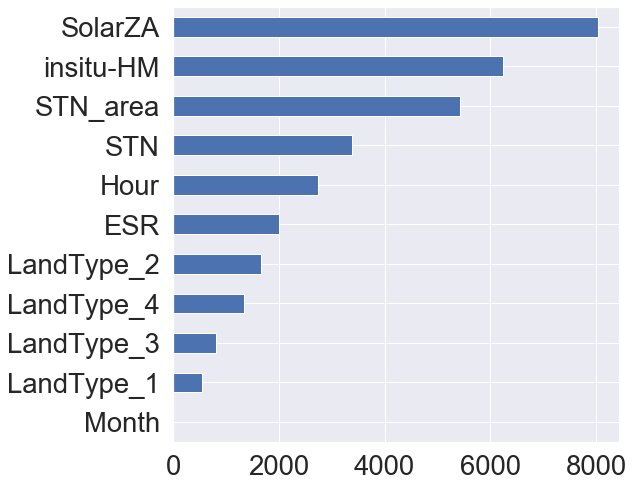

In [667]:
from pandas import Series

plt.figure(figsize=(8,8))
feature_importance = surface_lightgbm_model.feature_importances_
model_feats = Series(feature_importance, index = valid_surface_data.columns)
model_feats.sort_values(ascending= True).plot.barh()
plt.show()

In [655]:
valid_surface_data

,SolarZA,STN,STN_area,LandType_1,LandType_2,LandType_3,LandType_4,ESR,insitu-HM,Month,Hour
0,4.783298,0.90,0.693147,0,1,0,0,NaN,4.527761,7.0,0.0
1,4.783298,0.93,0.693147,0,0,1,0,NaN,4.559561,7.0,0.0
2,4.783298,0.95,0.000000,0,1,0,0,NaN,4.612136,7.0,0.0
3,4.783298,0.98,0.000000,0,1,0,0,NaN,4.601606,7.0,0.0
4,4.783298,0.99,0.000000,0,1,0,0,NaN,4.601606,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
54498,4.901273,9.73,2.079442,0,1,0,0,NaN,4.601606,8.0,23.0
54499,4.901273,9.74,1.791759,0,1,0,0,NaN,4.569994,8.0,23.0
54500,4.894096,9.77,1.386294,0,1,0,0,NaN,4.601606,8.0,23.0
54501,4.879227,9.78,0.693147,0,1,0,0,NaN,4.612136,8.0,23.0


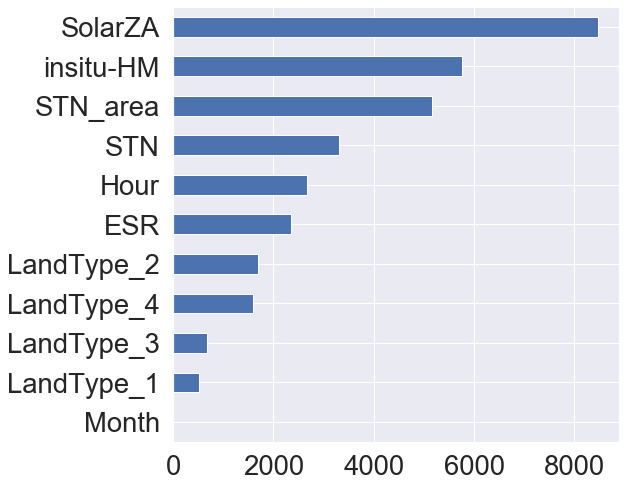

In [668]:
from pandas import Series

plt.figure(figsize=(8,8))
feature_importance = ground_lightgbm_model.feature_importances_
model_feats = Series(feature_importance, index = valid_surface_data.columns)
model_feats.sort_values(ascending= True).plot.barh()
plt.show()